In [2]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
import graphviz 
plt.rcParams.update({
    'figure.dpi' : 150
})


In [3]:
test_survived = pd.read_csv('gender_submission.csv')
test_set = pd.read_csv('test.csv').merge(test_survived, on='PassengerId')
train_set = pd.read_csv('train.csv')
dfs = [train_set, test_set]

remapper = {
    'Survived' : {
        0 : 'Died',
        1 : 'Survived'
    },
    'Embarked' : {
         'C' : 'Cherbourg', 
         'Q' : 'Queenstown',
         'S' : 'Southampton'
    },
    'Pclass' : {
        1 : 'First class',
        2 : 'Second class',
        3 : 'Third class'
    }
}
[df.replace(remapper, inplace= True) for df in dfs]

total_set = pd.concat(dfs)

# Trying to practice with MultiIndex
dfs = {i : eval(i).reset_index() for i in ['train_set', 'test_set', 'total_set']}
total_df = pd.concat(dfs, axis =0).drop(columns='index').drop(columns=['PassengerId'])

# Meaning of columns:

| Column Name | Meaning | Values |
|---|---|---|
| Survived | If survived | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | sex | Male / Female |
| Age | Age in years | xx.5 = guess, 0.?? months (float) |
| Sibsp | Number of siblings / spouses aboard | int |
| Parch | Number of parents / children aboard | int | 
| Ticket | Ticket number | string |
| Fare | Passenger fare | float |
| Cabin | Cabin number | string |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

# (Small) Categorical columns

/tmp/ipykernel_5637/185292311.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(df_dict), figsize = (5*len(df_dict), 5), sharex=True, sharey=True)


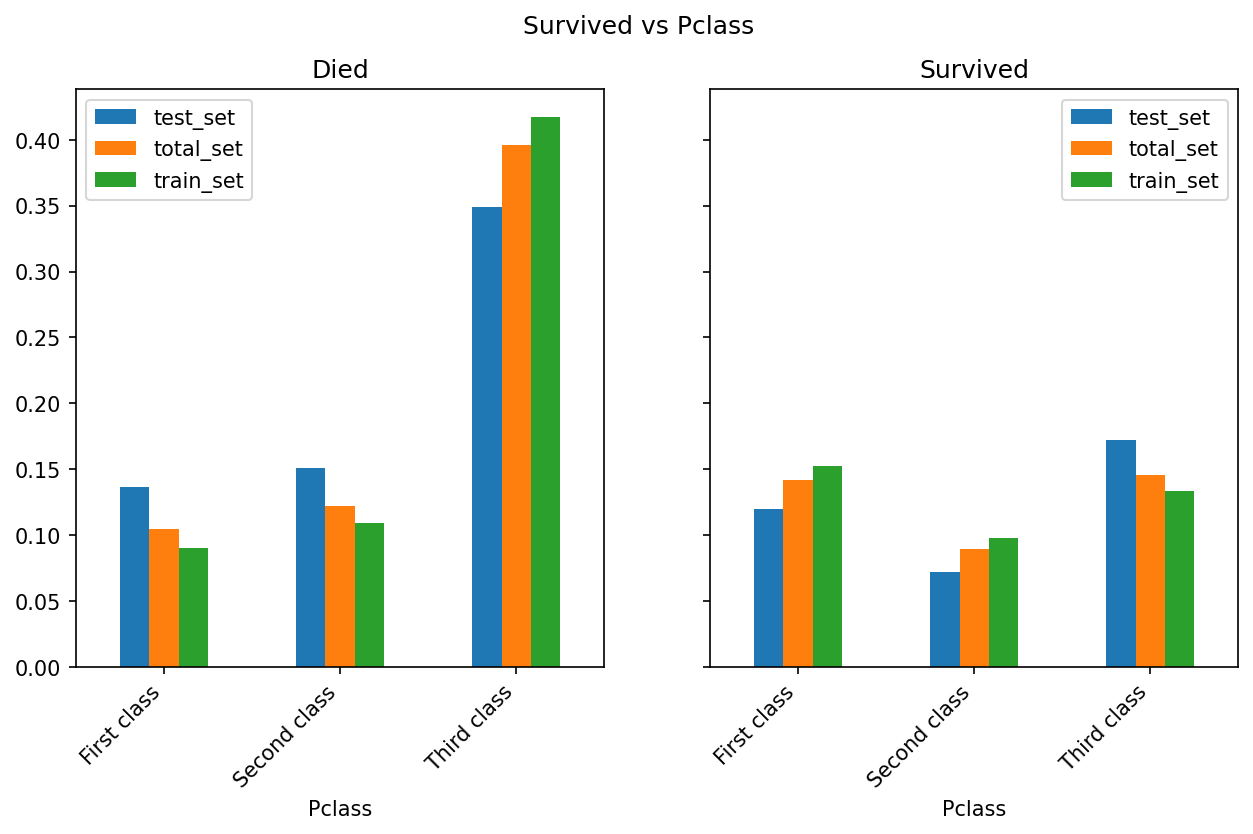

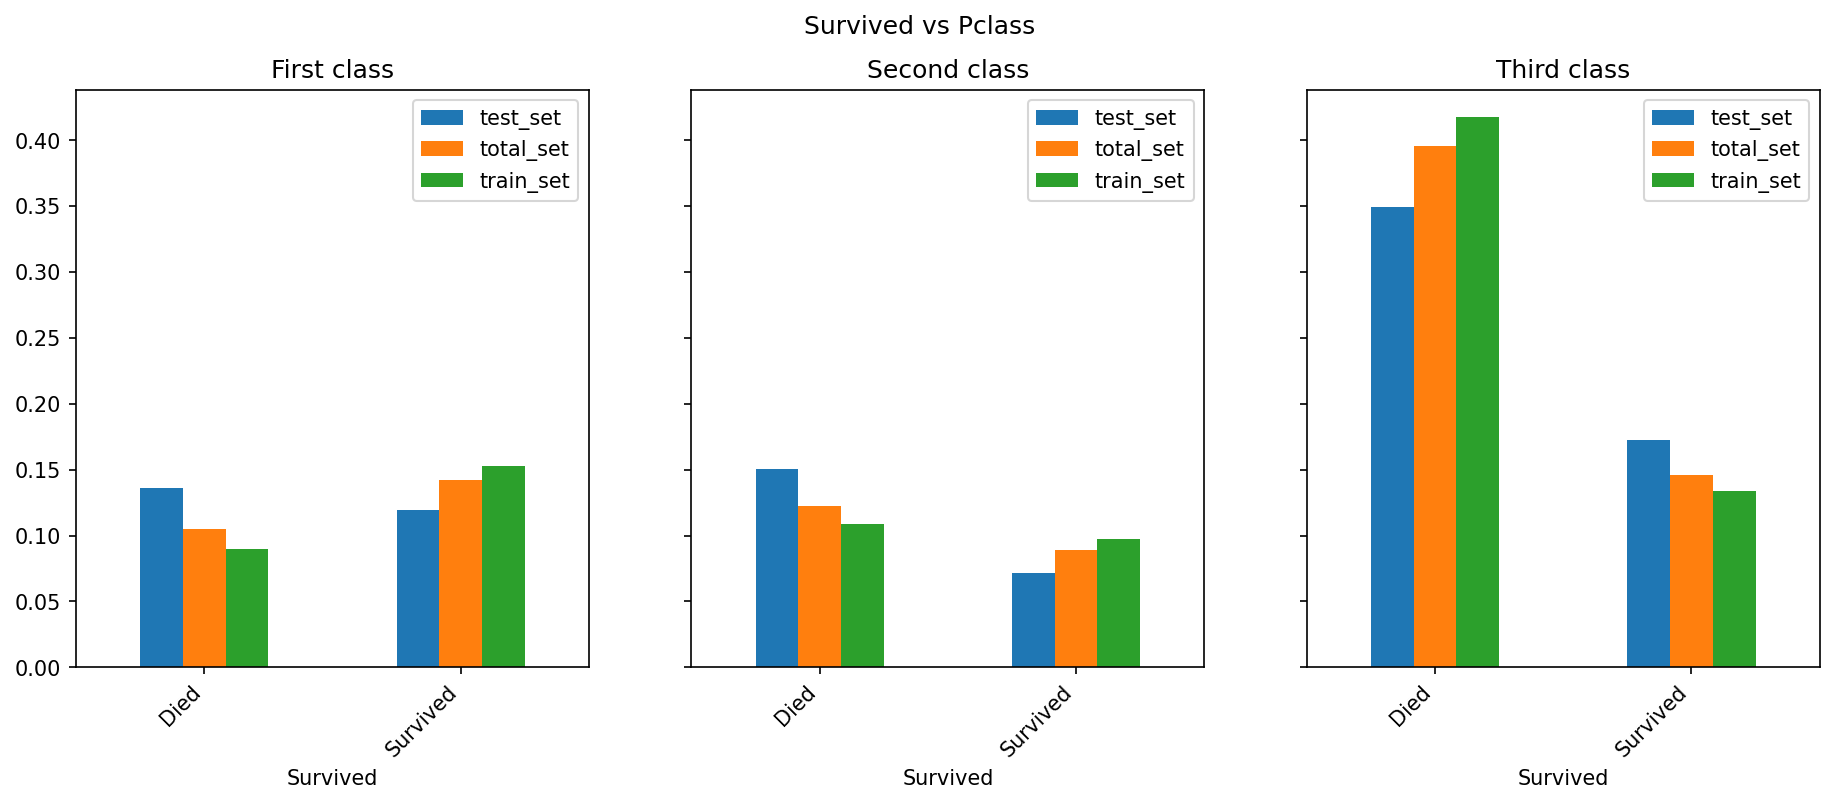

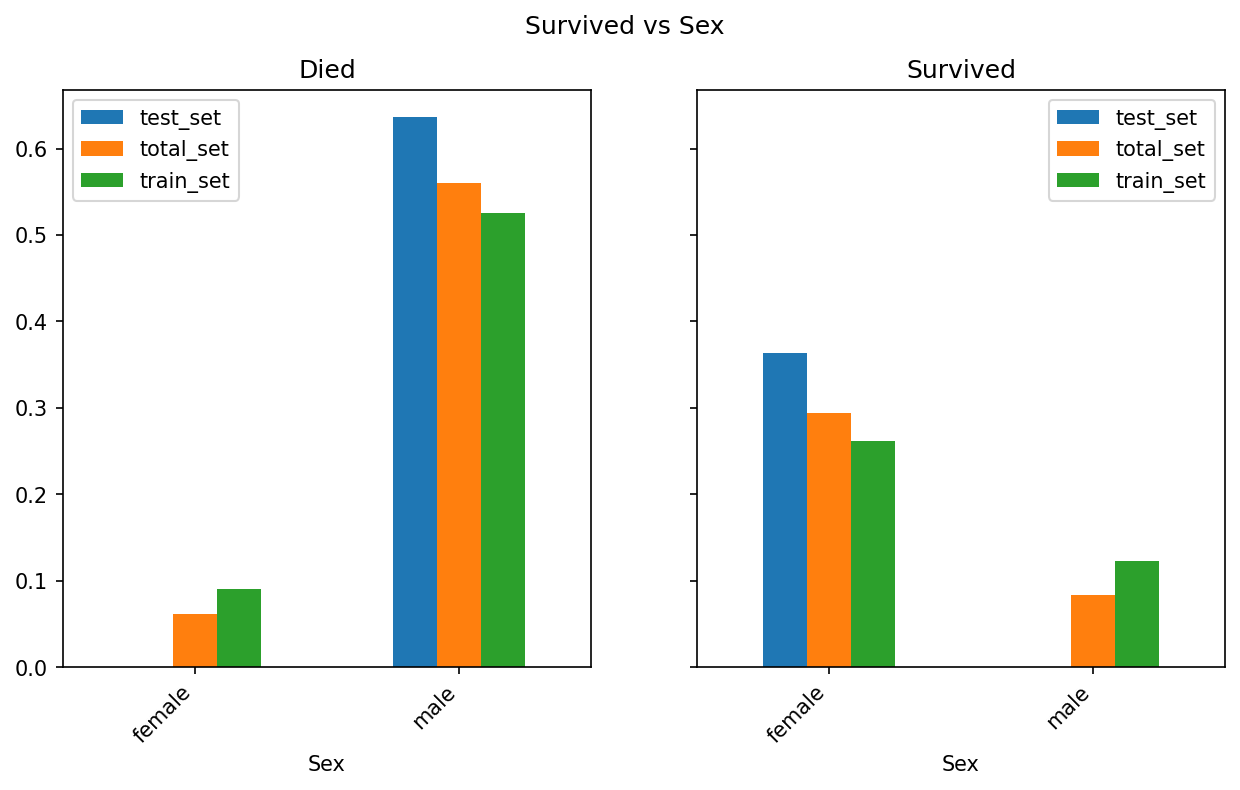

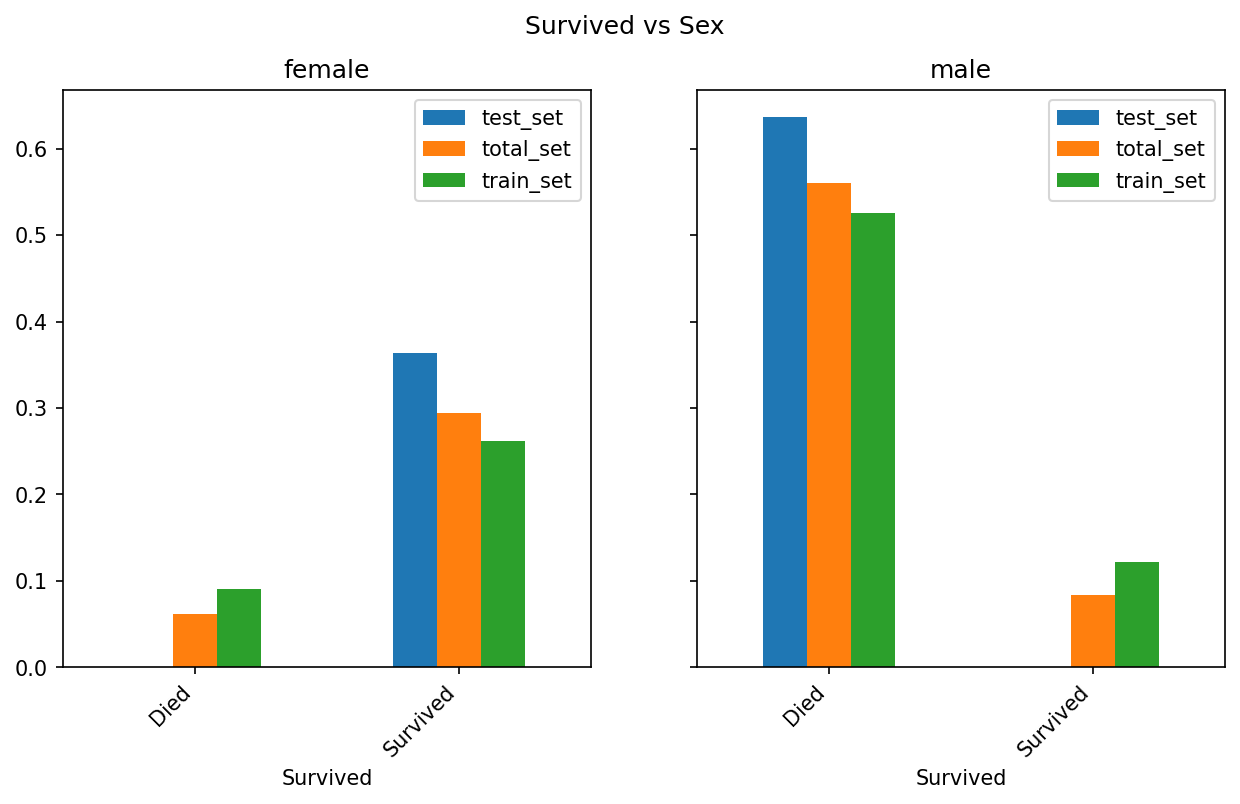

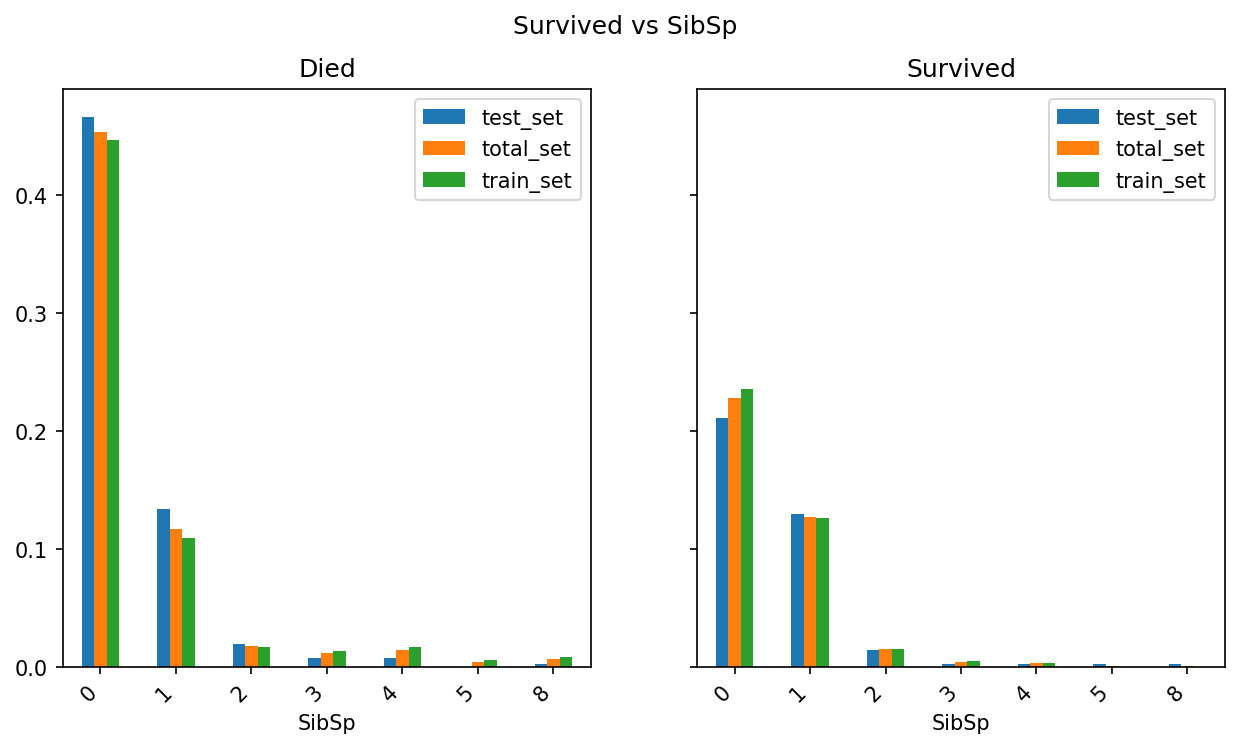

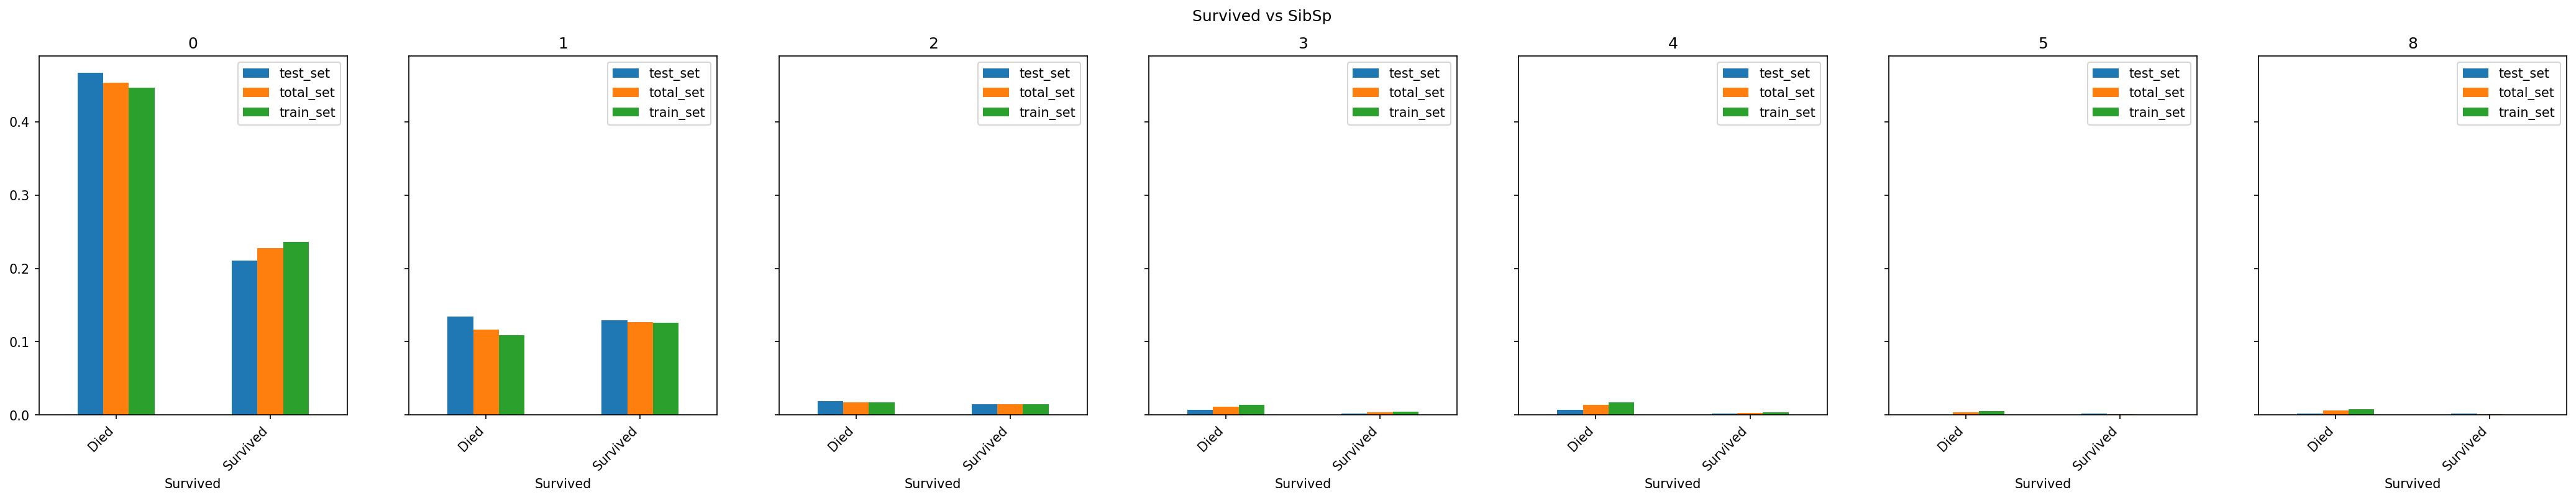

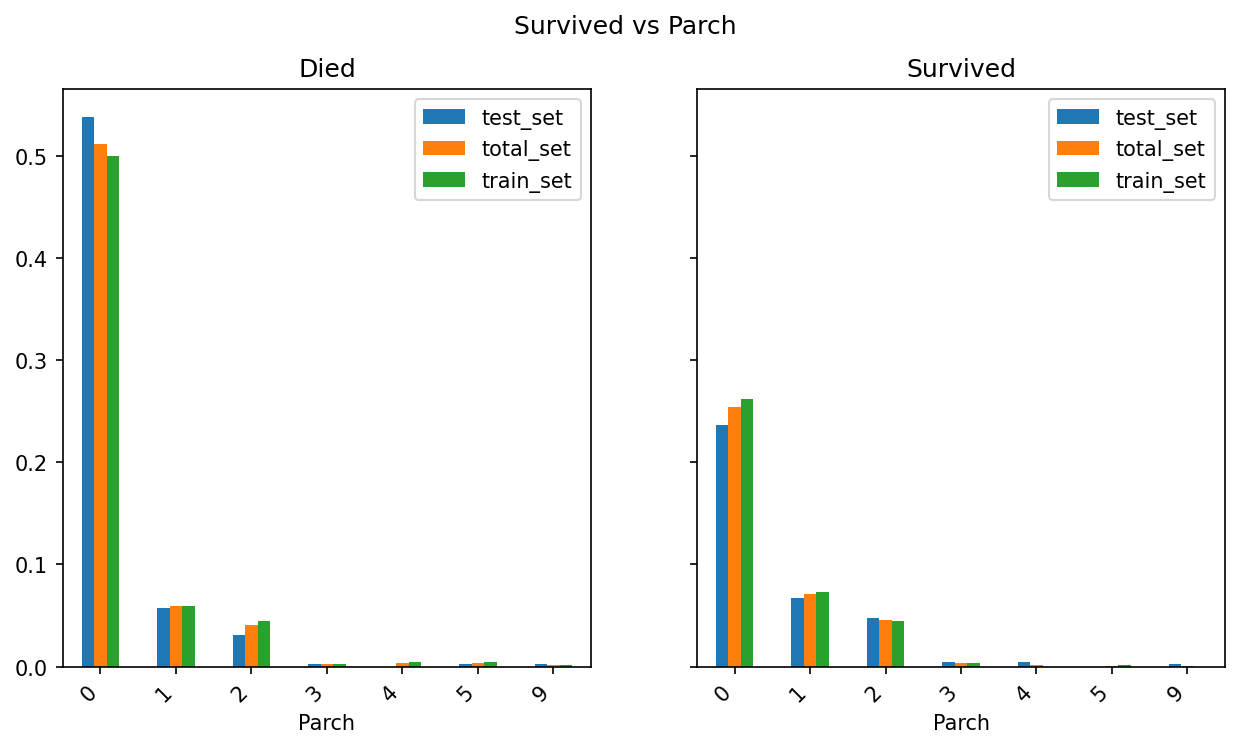

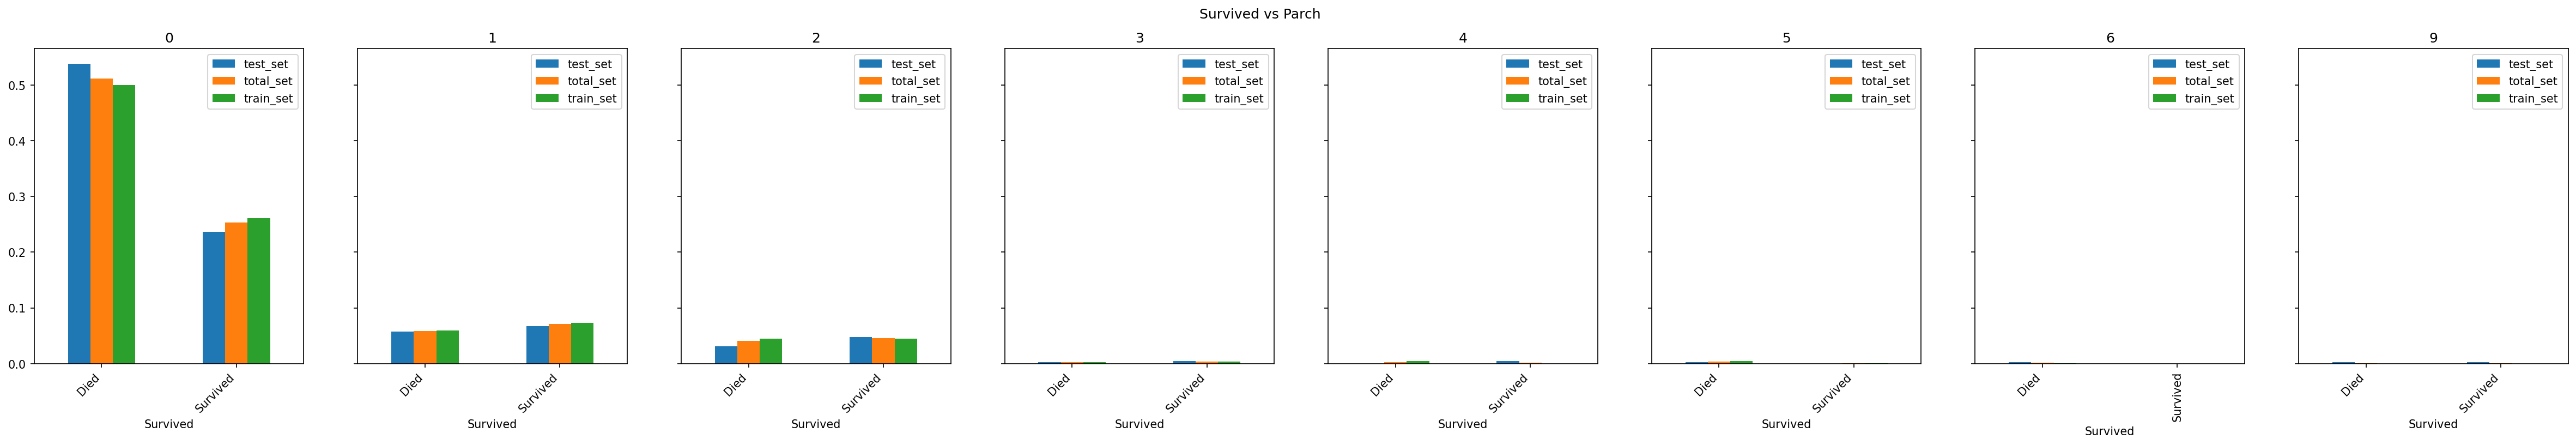

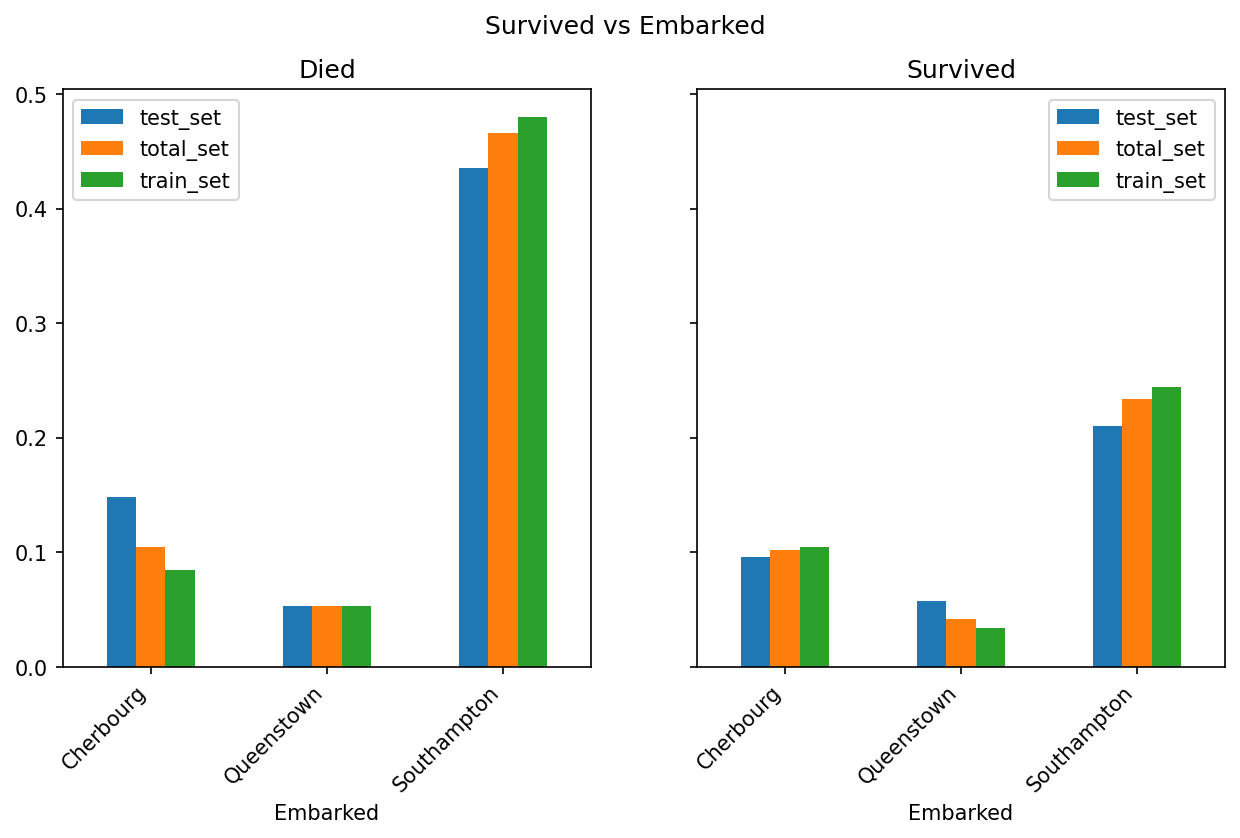

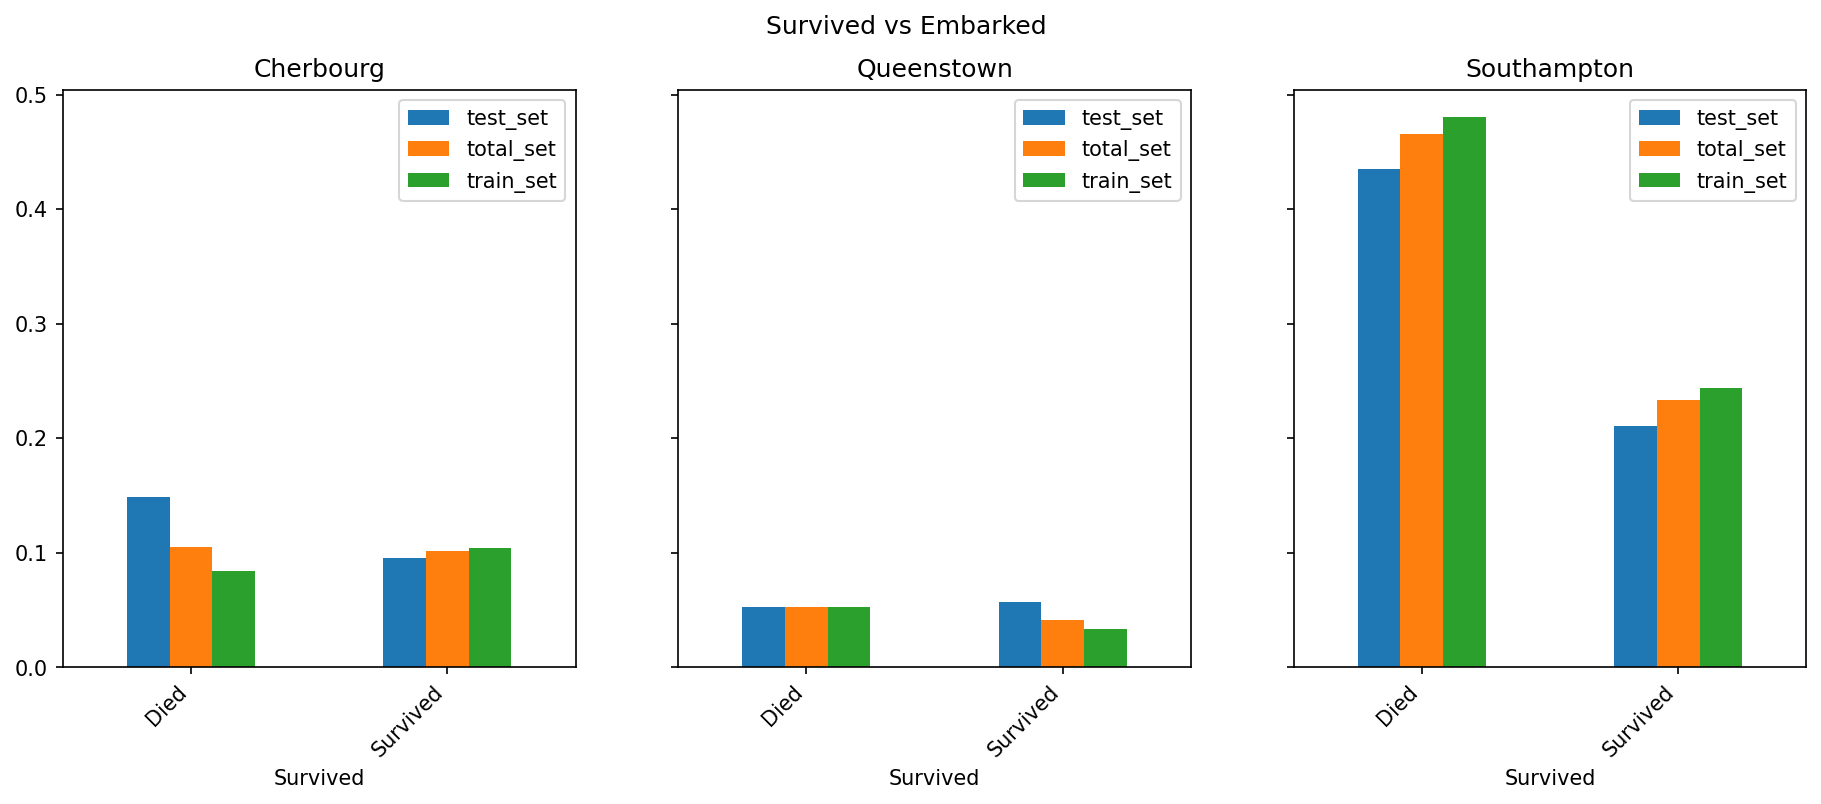

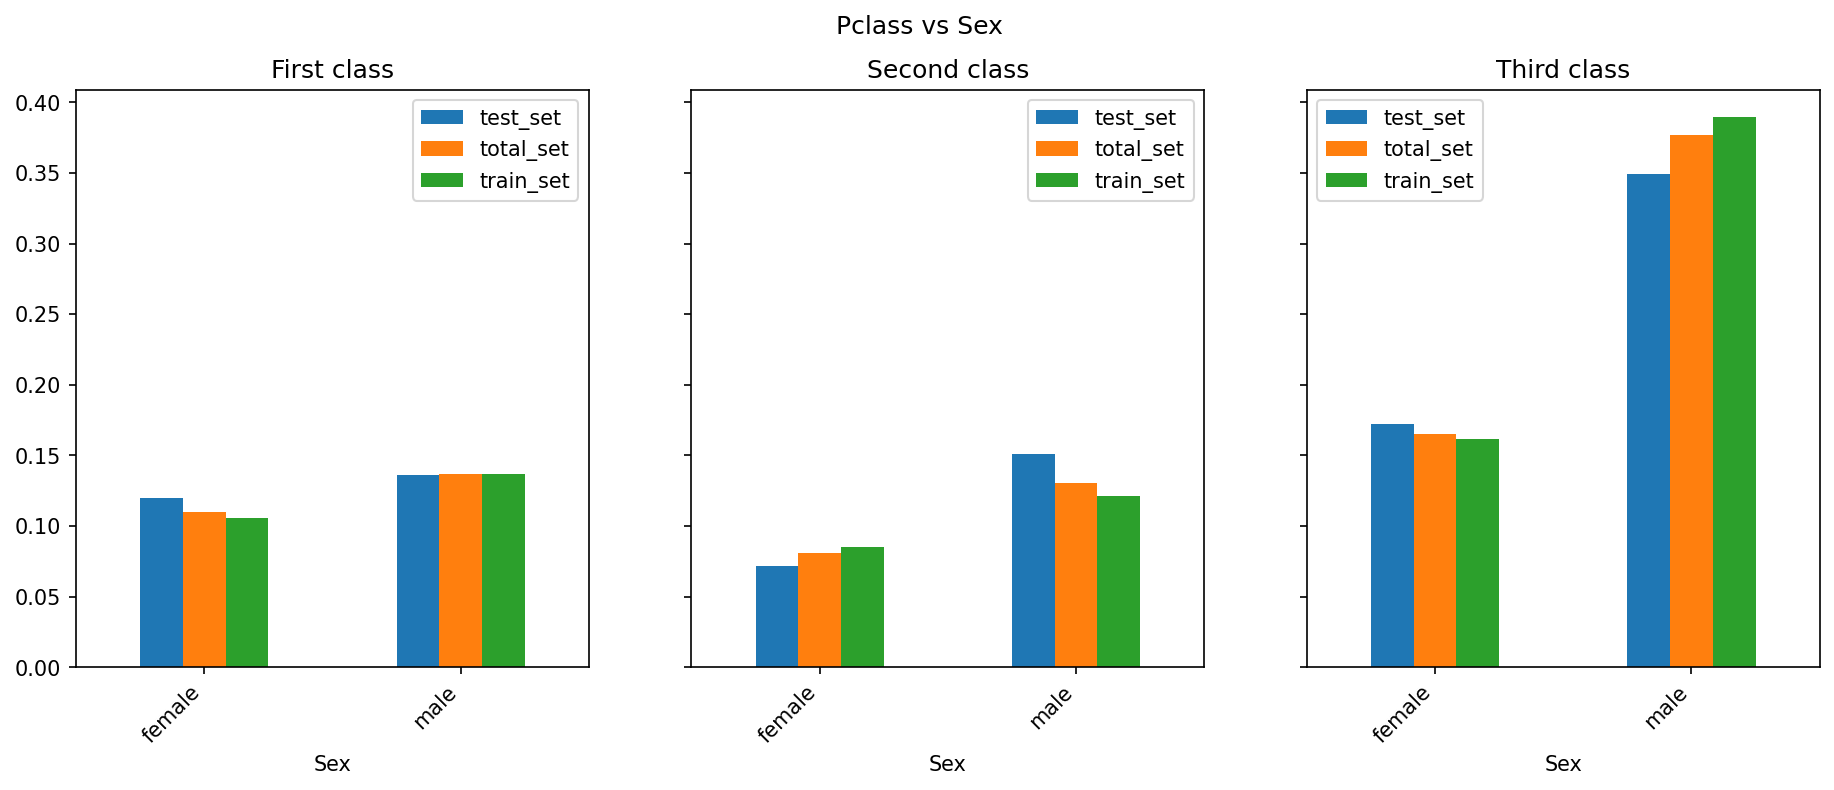

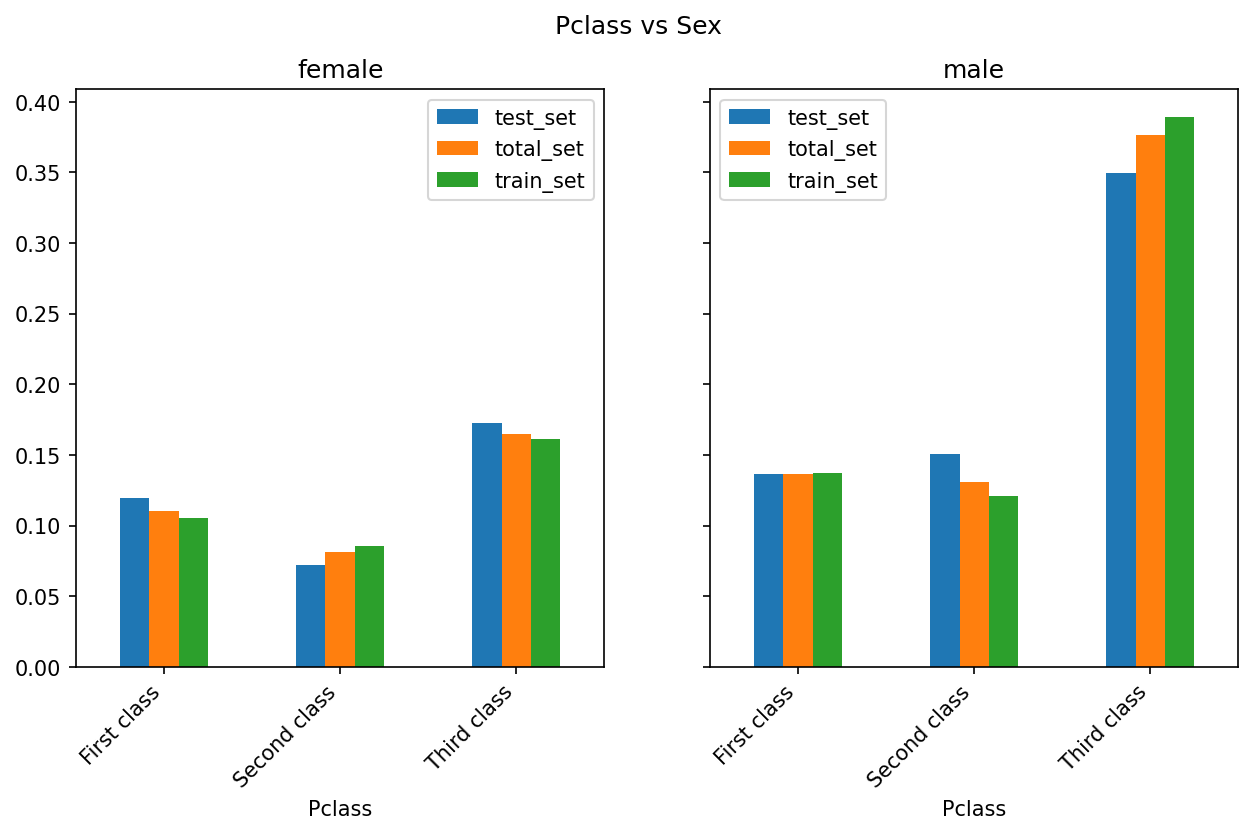

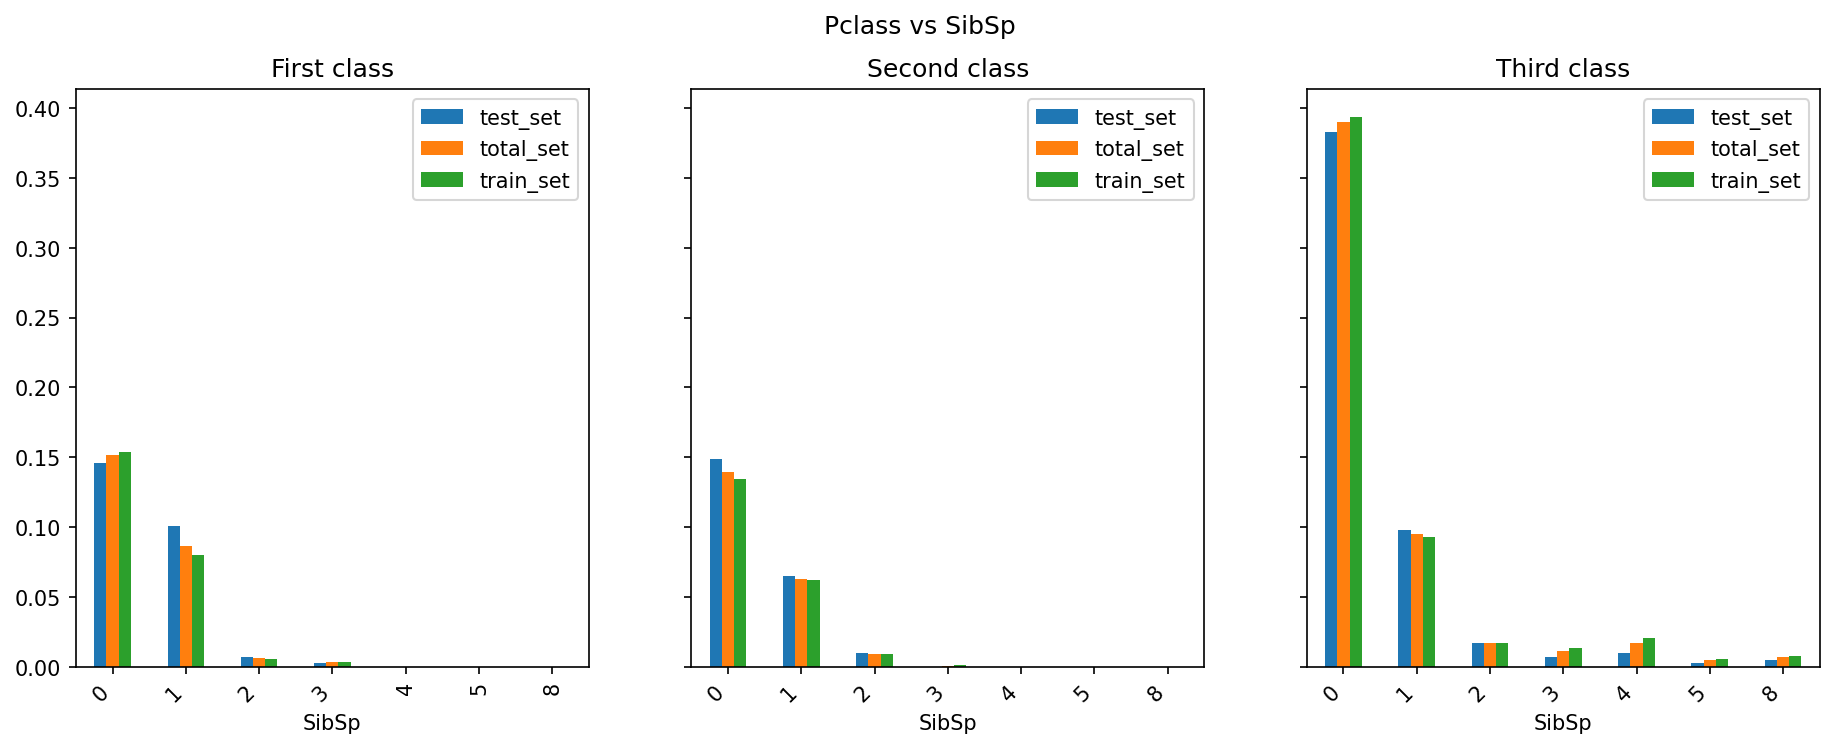

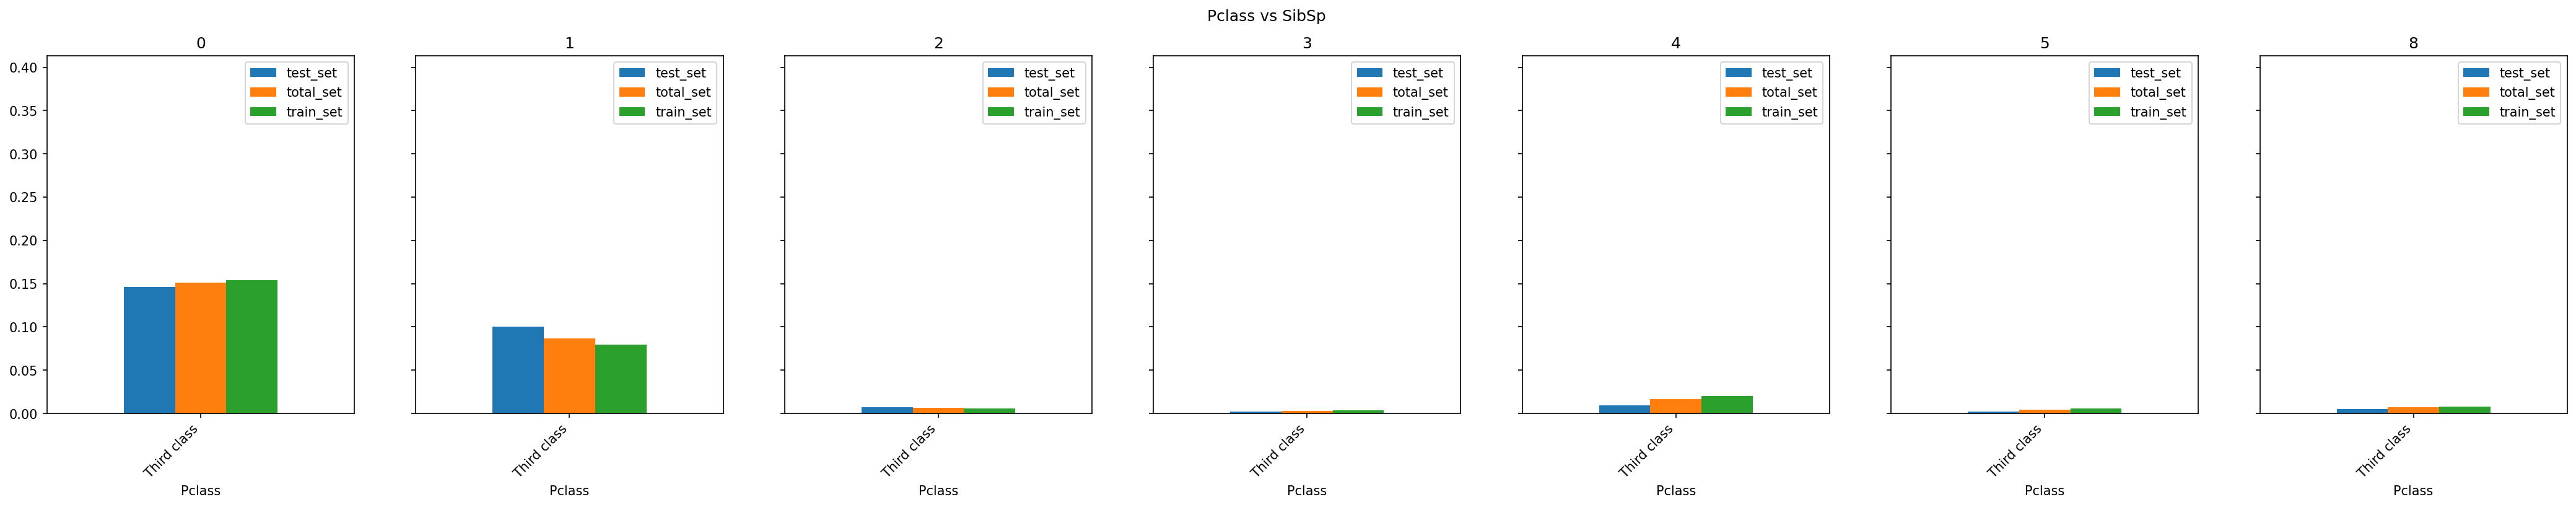

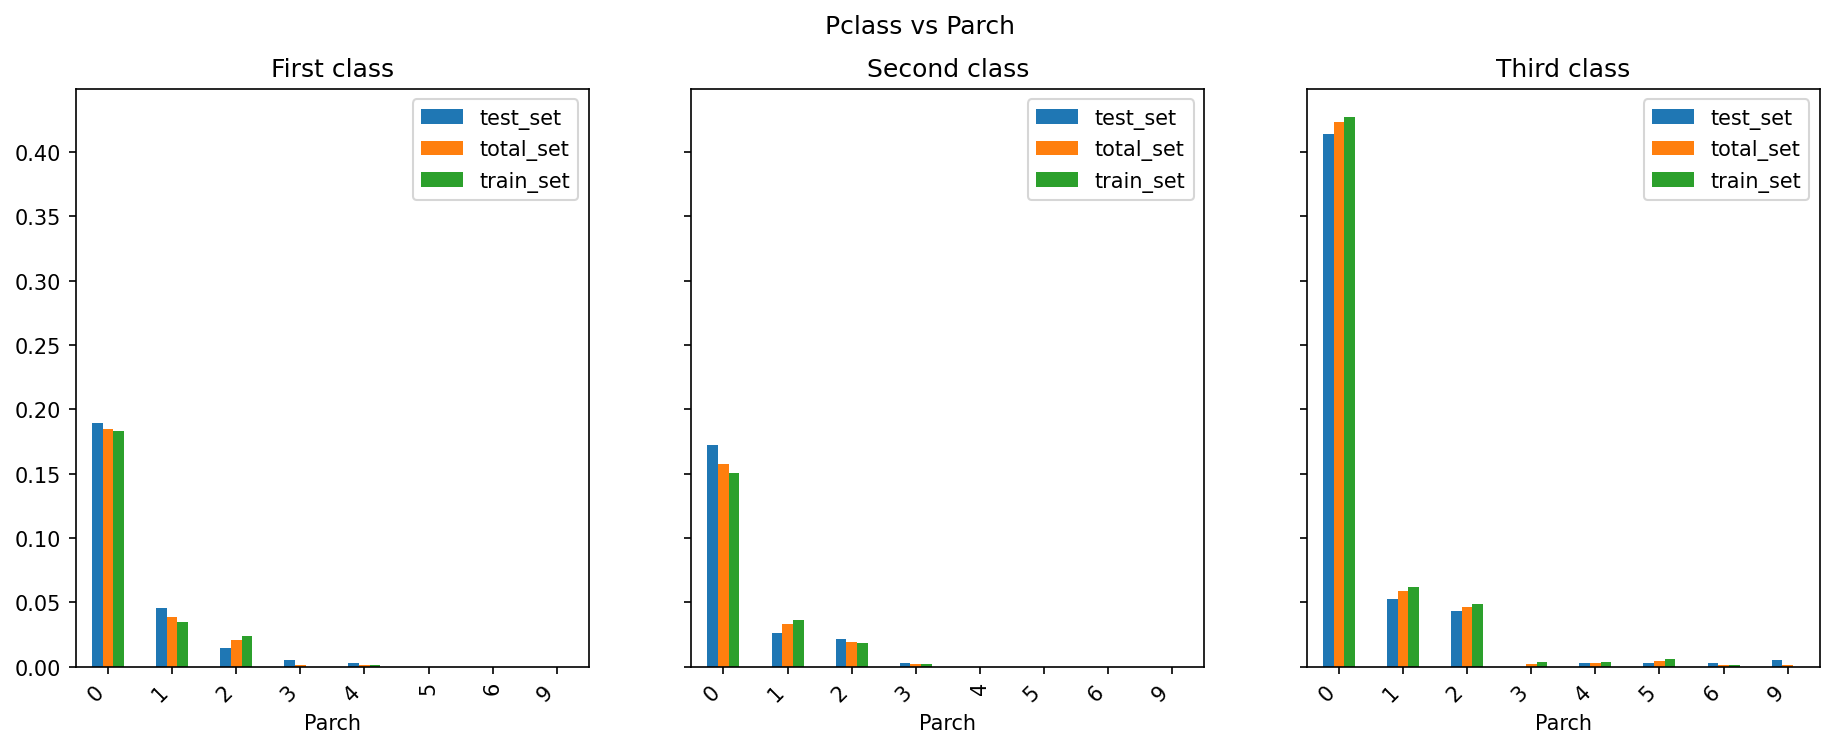

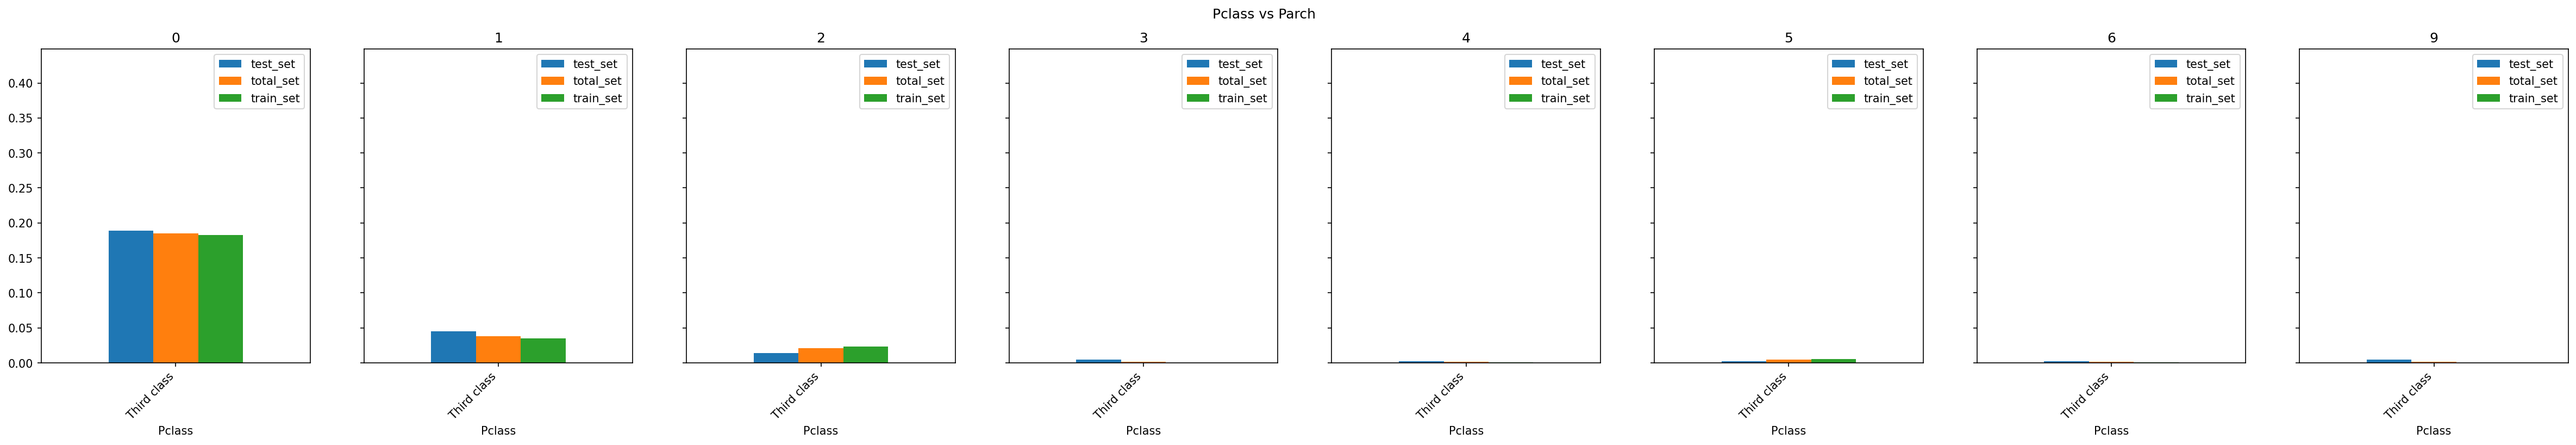

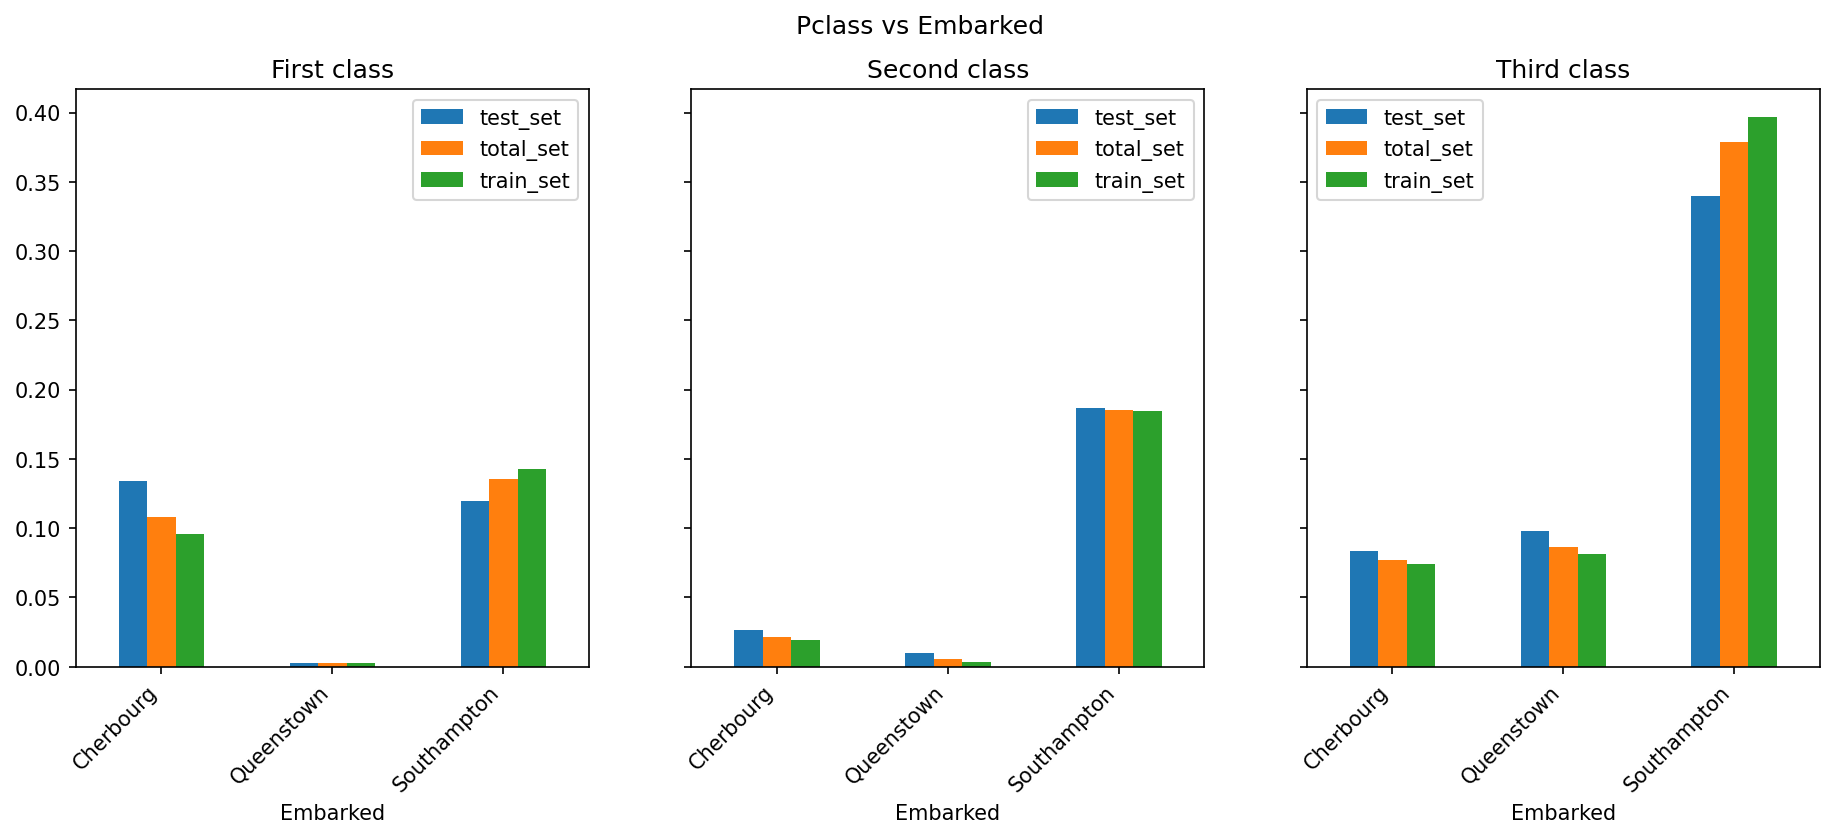

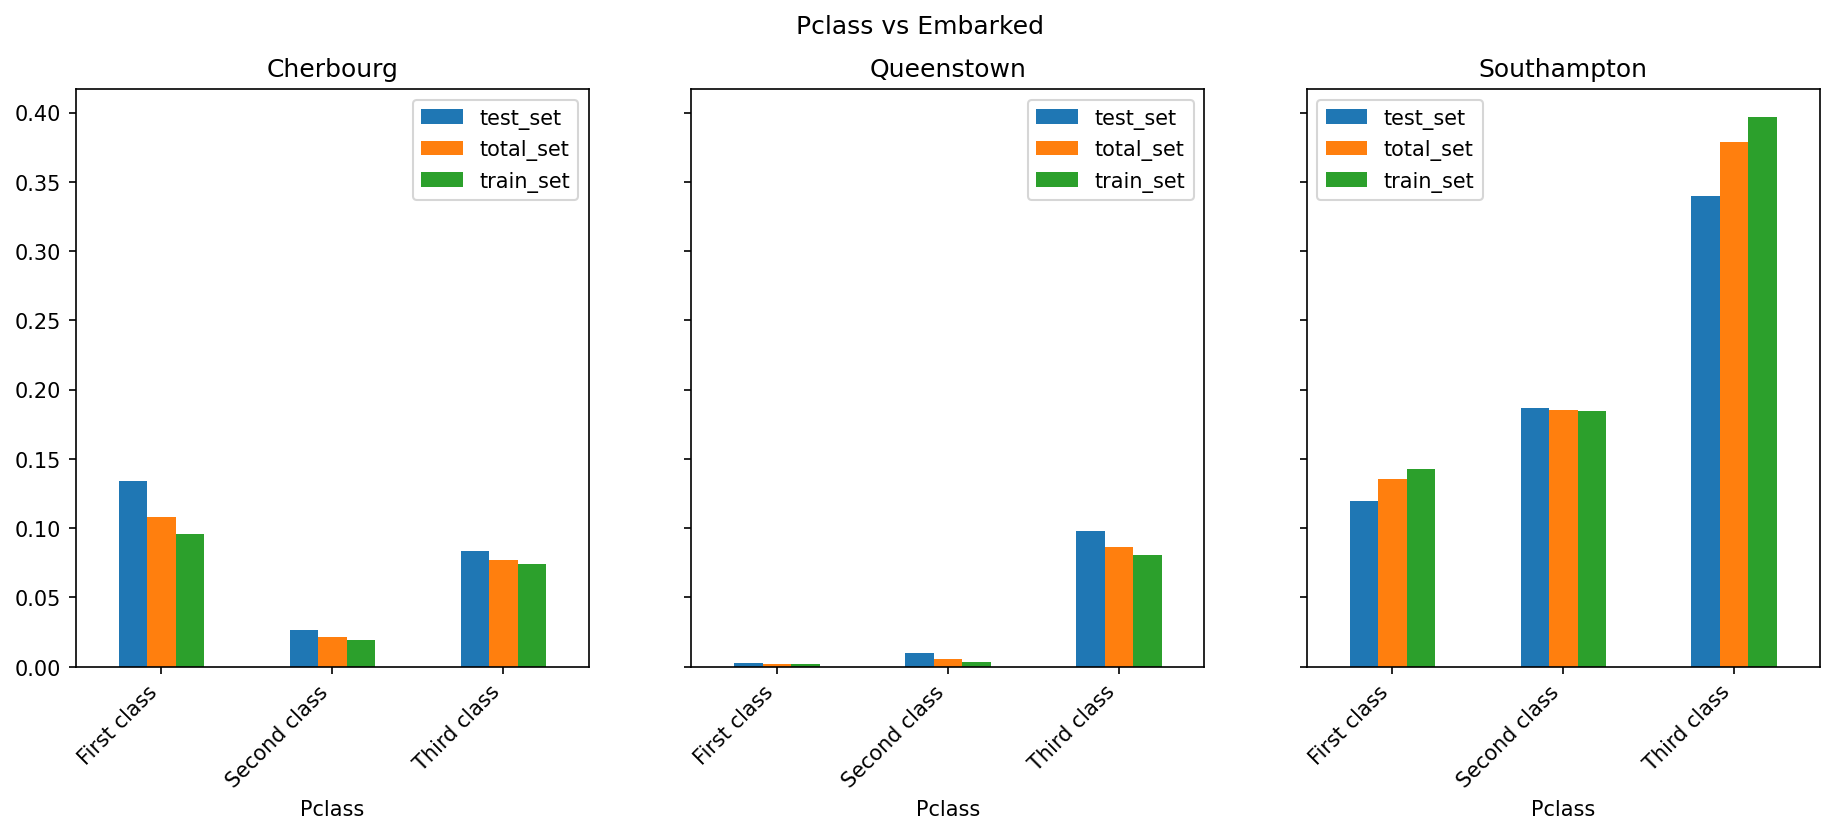

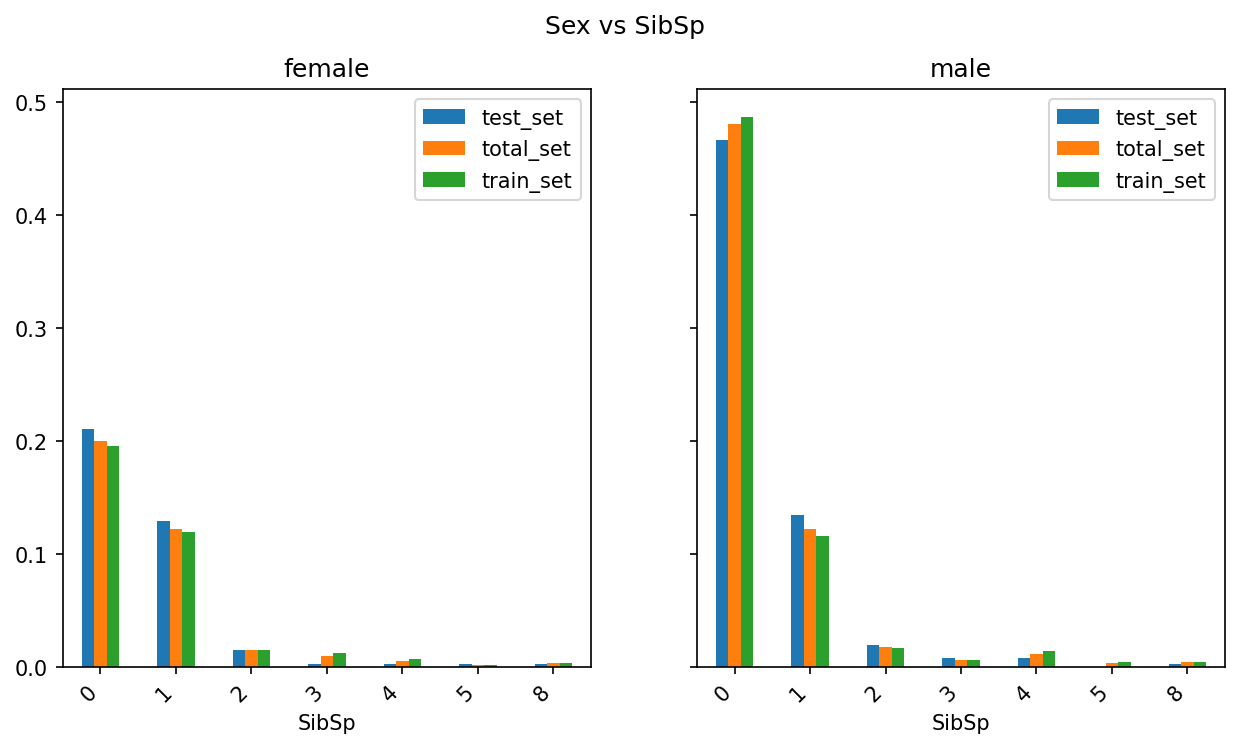

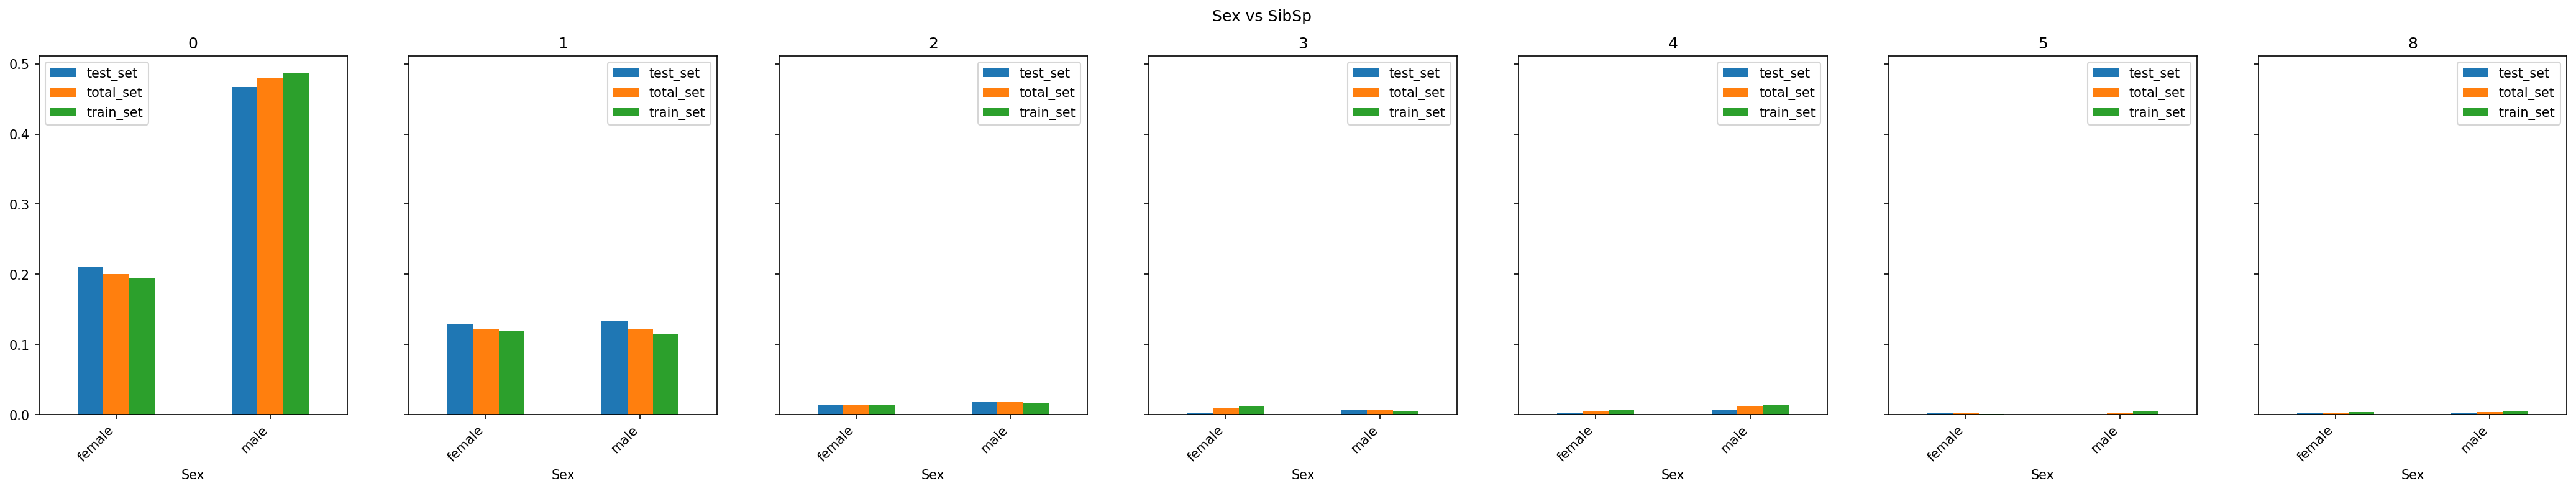

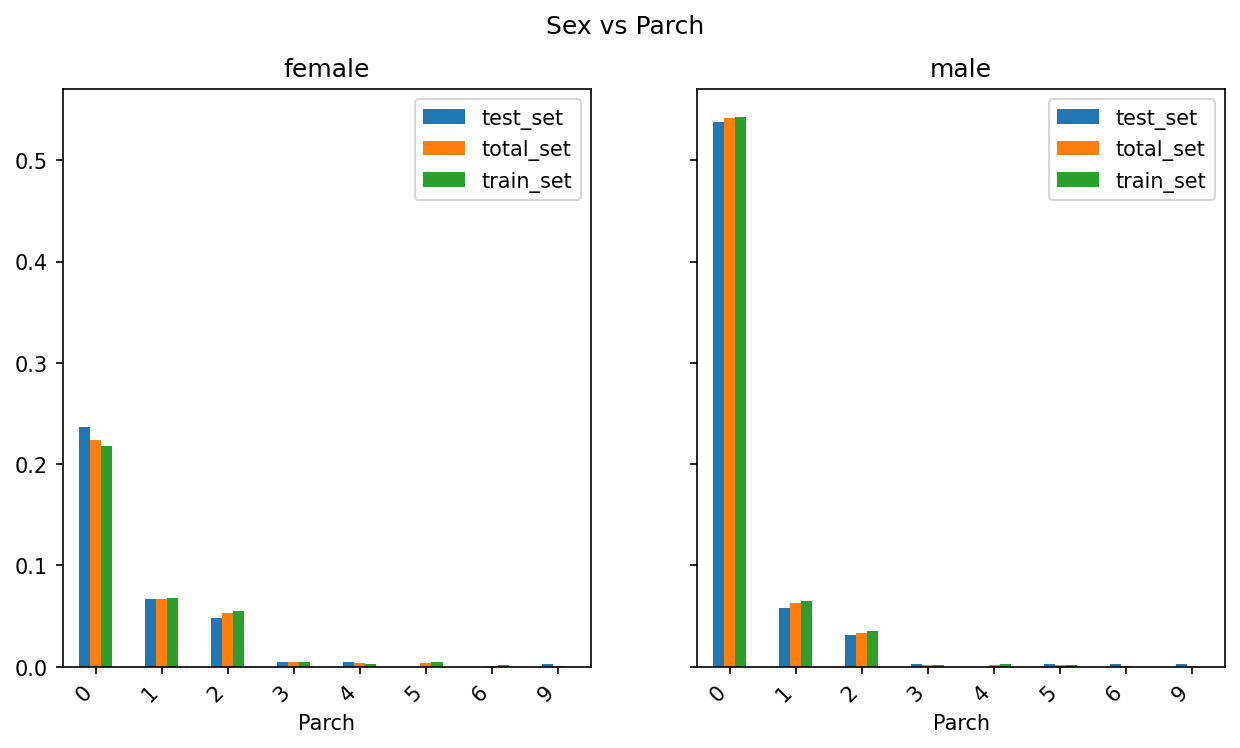

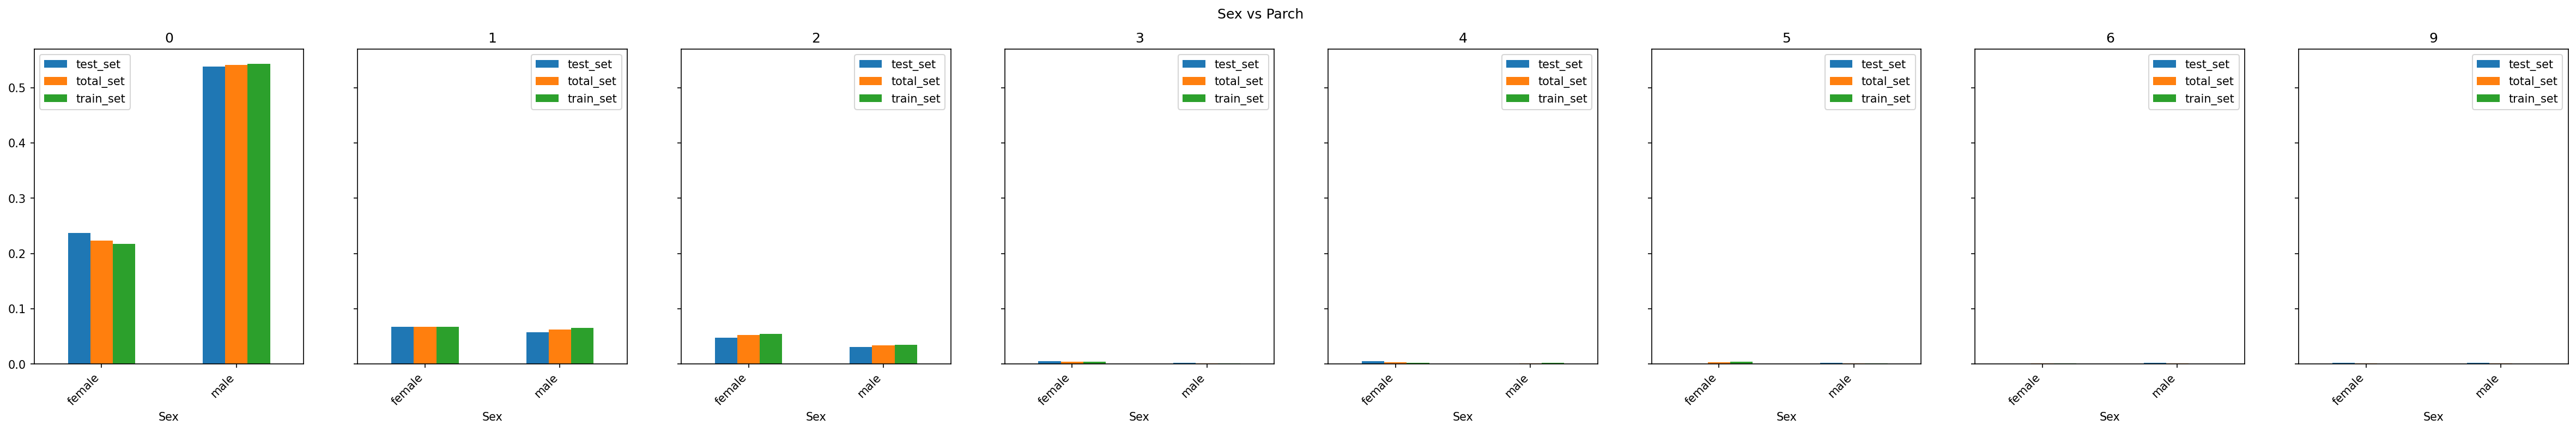

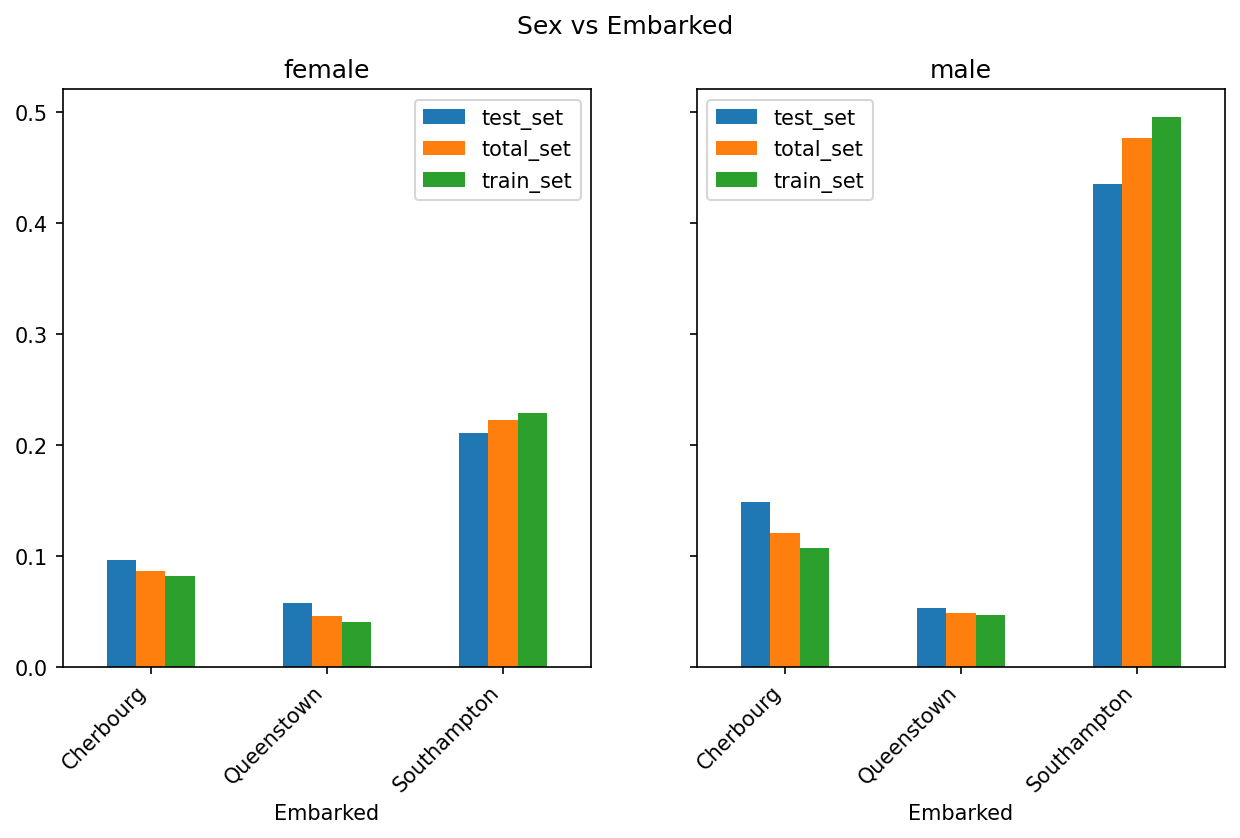

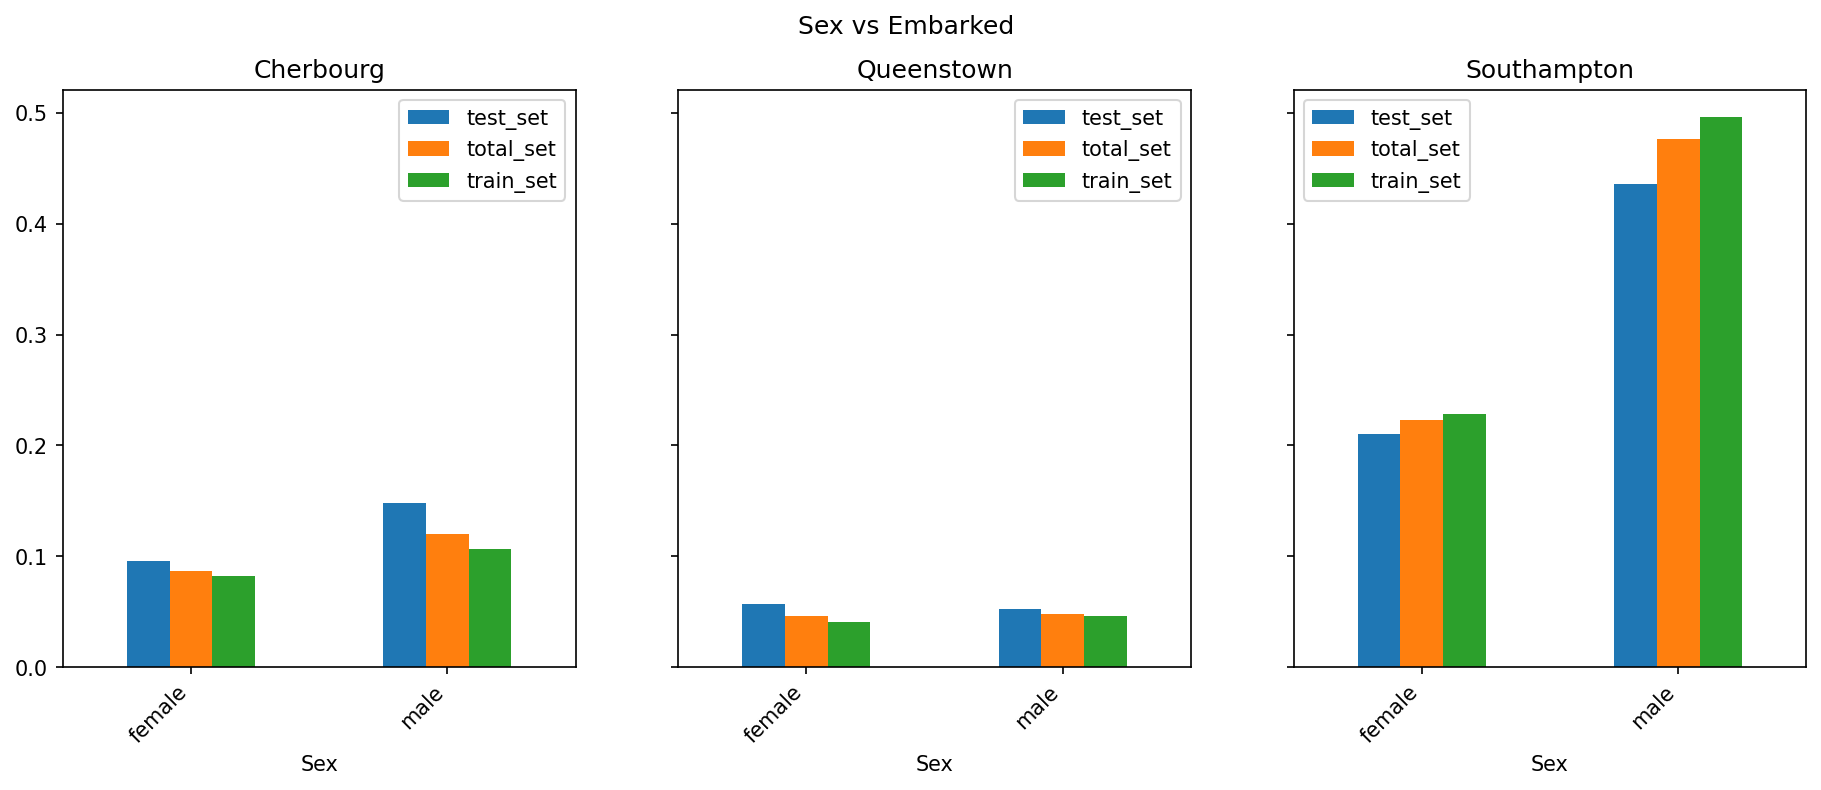

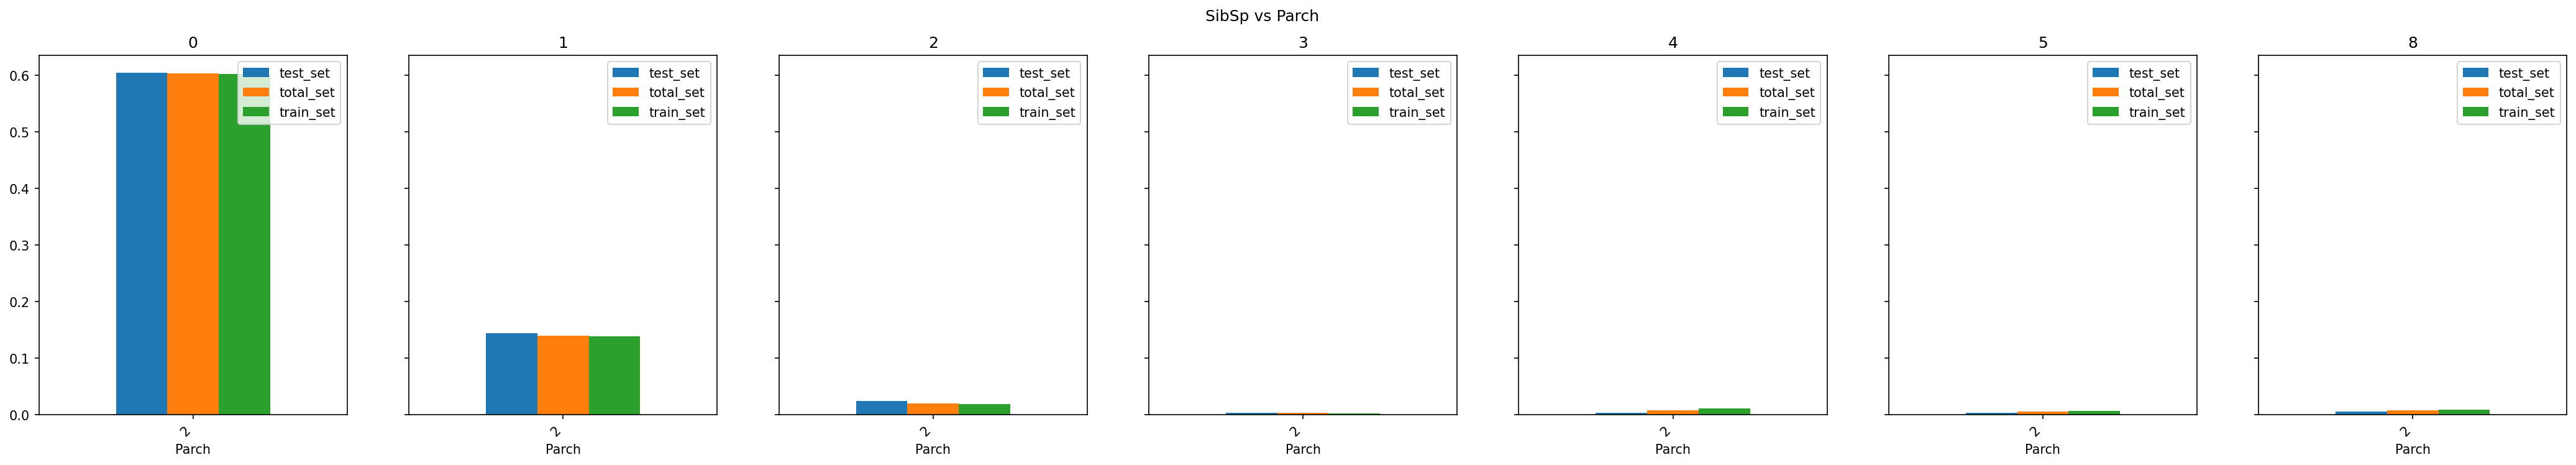

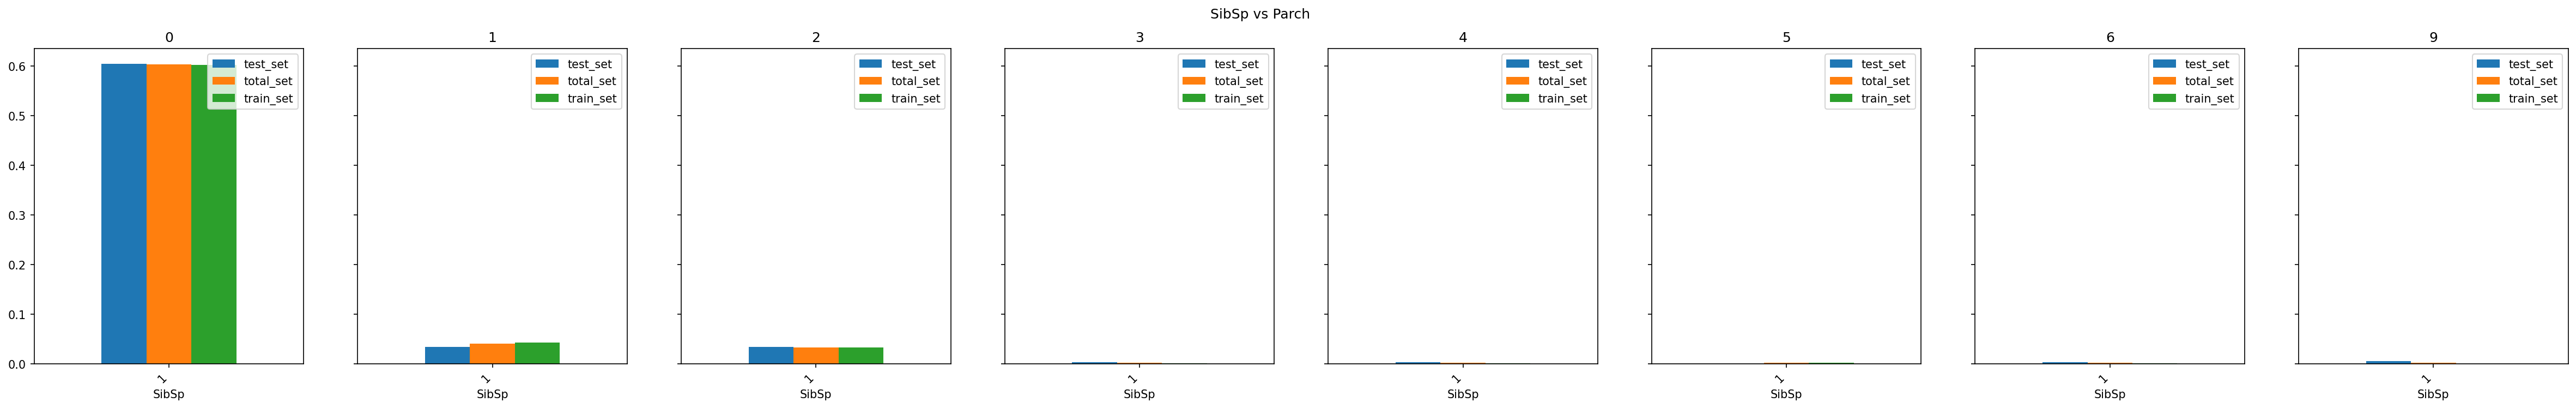

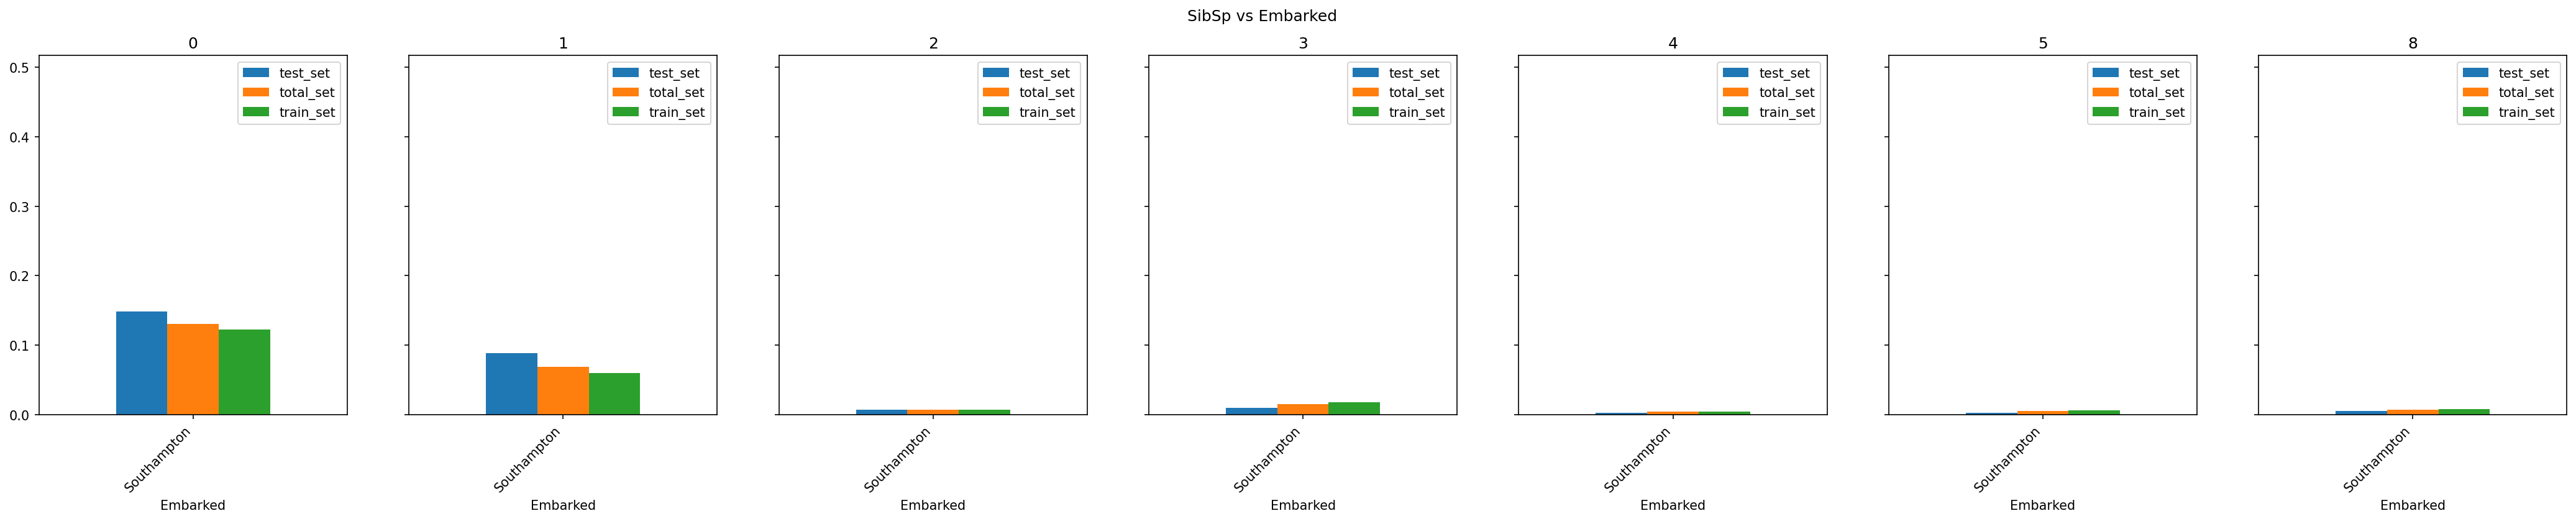

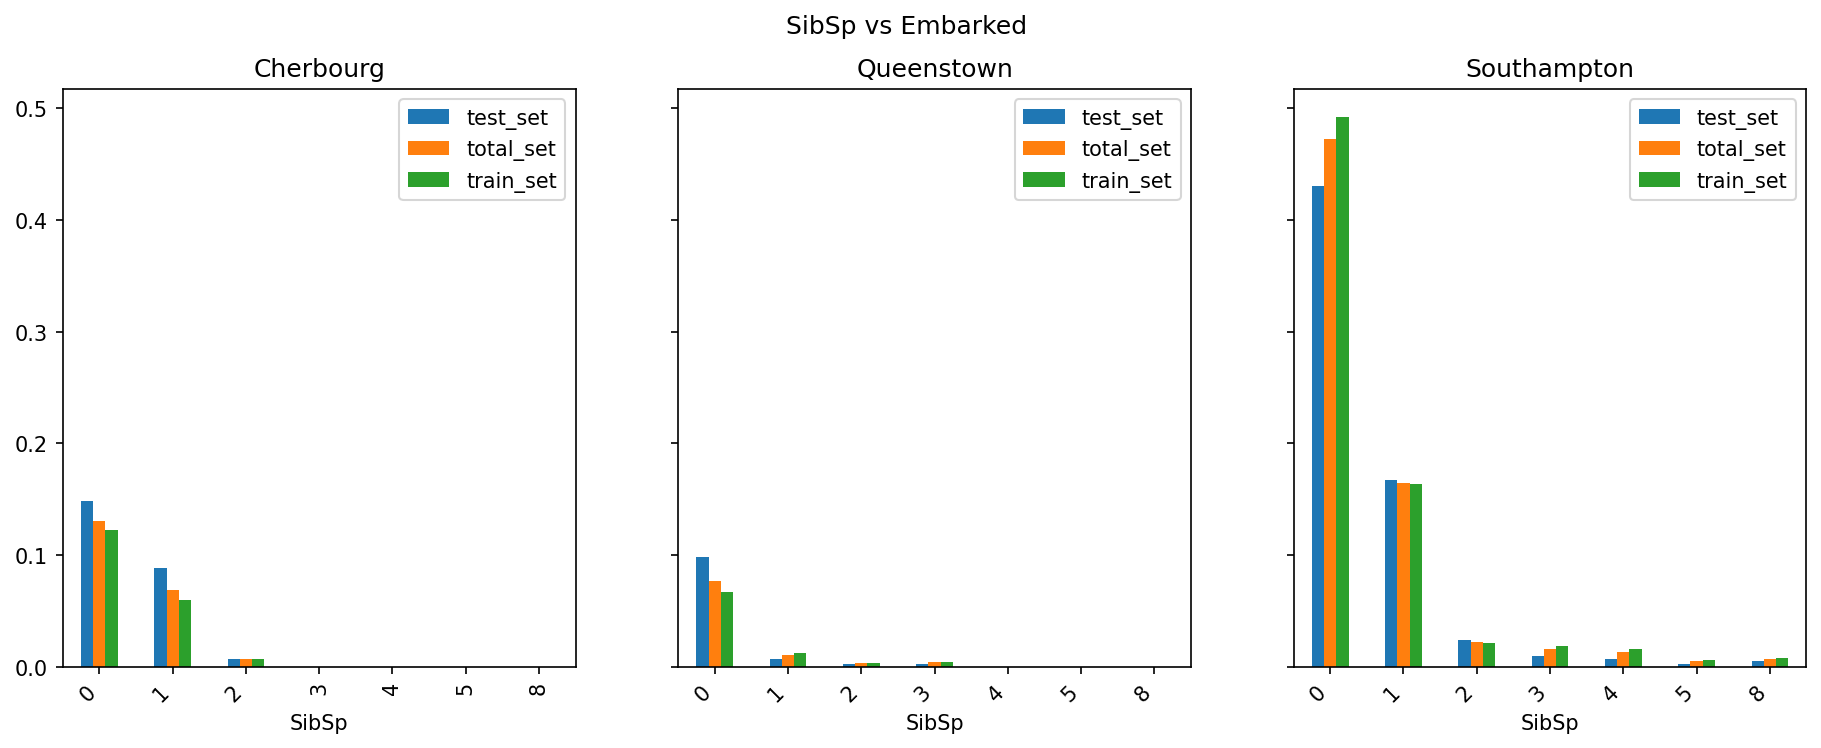

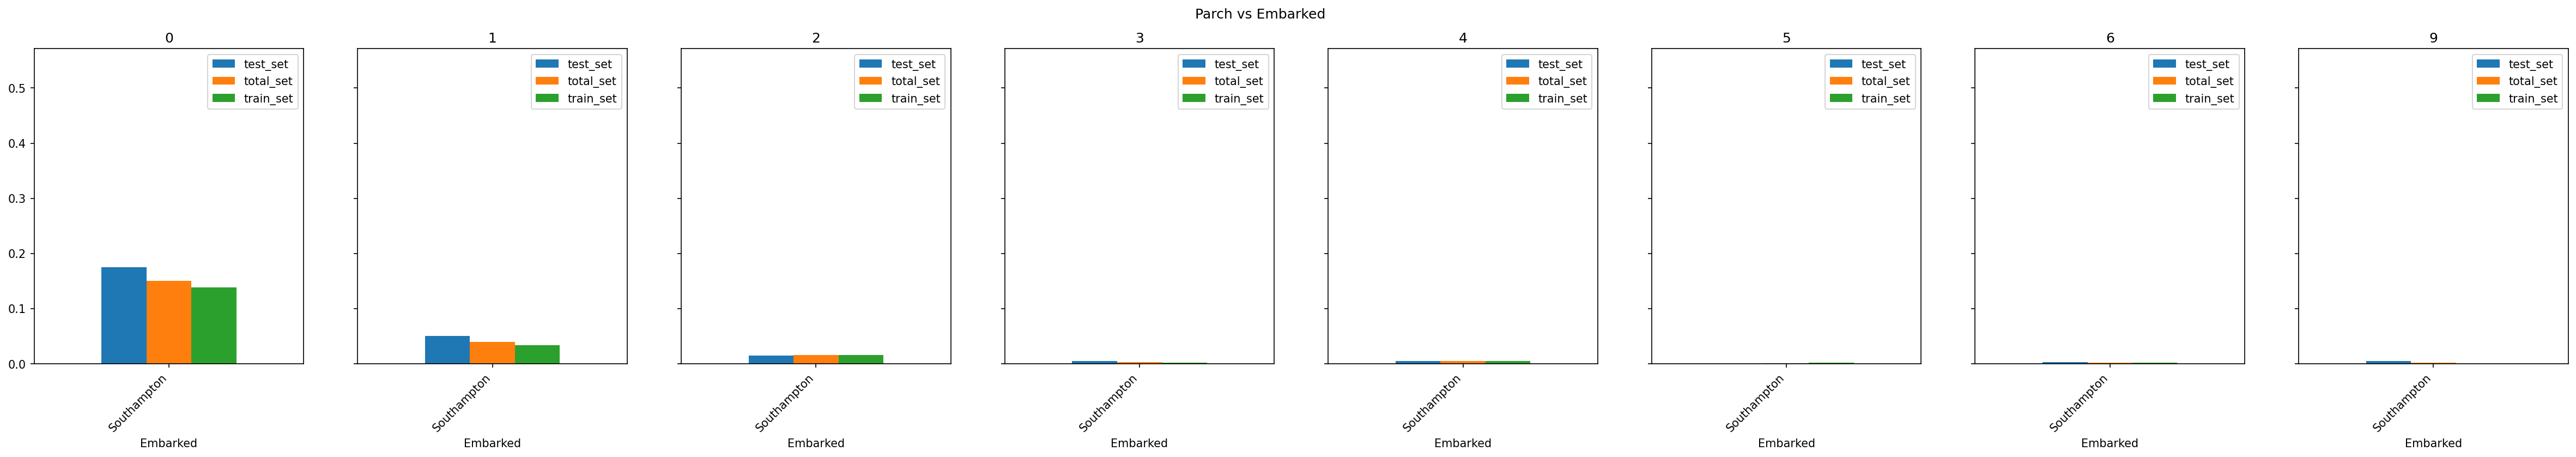

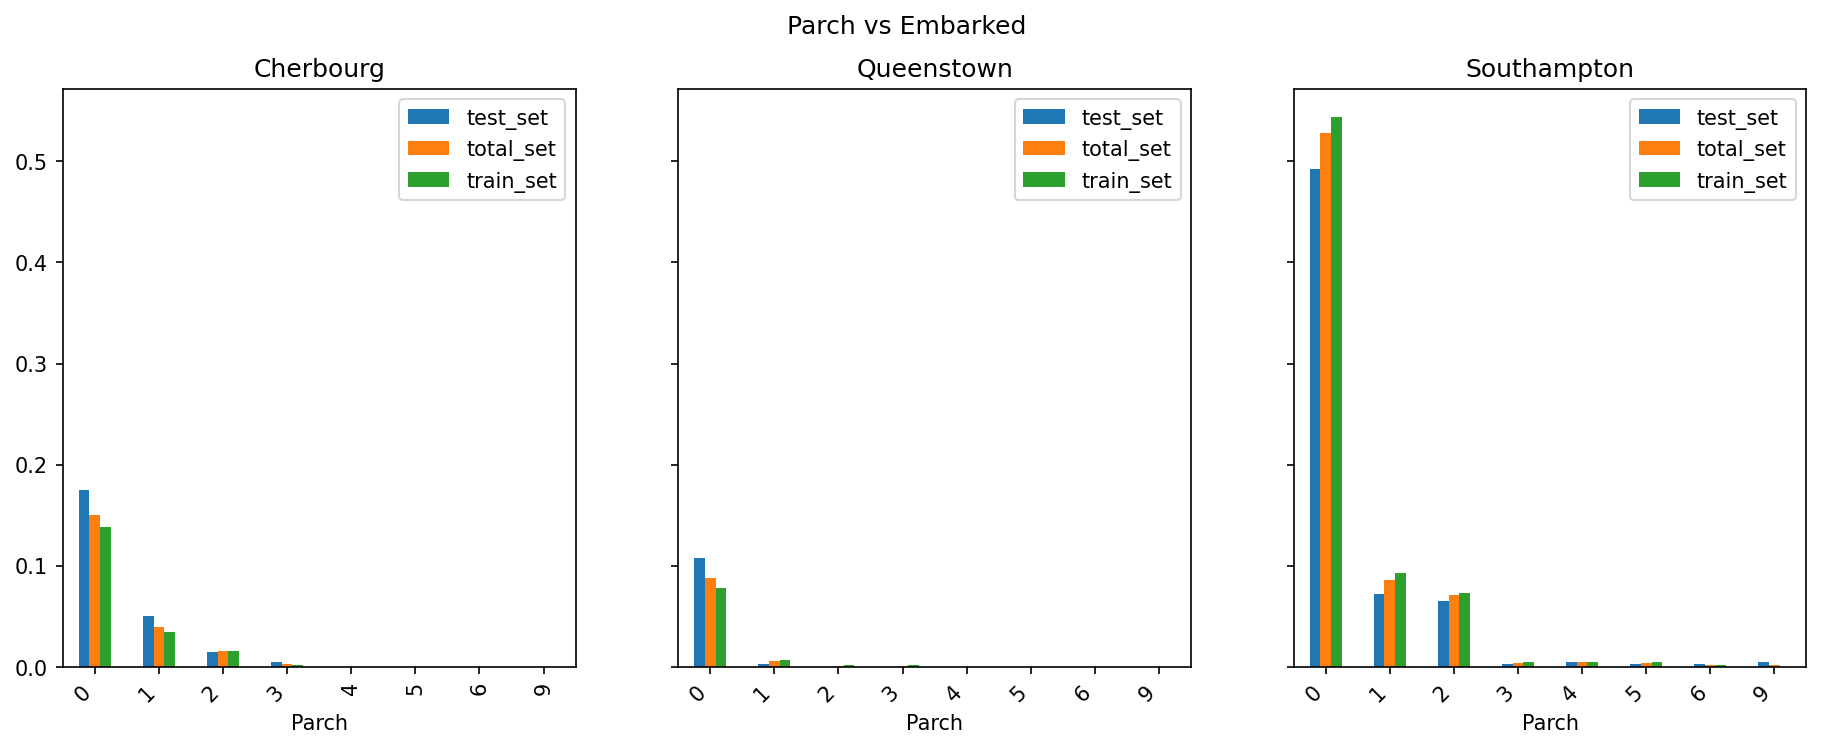

In [4]:
cutoff = 10

# Counts number of unique values in each column to filter with a cut off 
nuniques = total_df.apply(lambda x: x.nunique())
small_catergories = nuniques[nuniques < cutoff].keys()

# Make all combinations to plot against each other
small_catergories_permutations = combinations(small_catergories, 2)
for permutation in small_catergories_permutations:
    permutation = list(permutation)
    survived_percent = total_df.groupby(level=0)[permutation].value_counts(normalize=True)
    unstacked_df = survived_percent.unstack(level=0)
    for i in range(2):
        df_dict = {k: v.droplevel(permutation[i]) for k, v in unstacked_df.groupby(permutation[i])}
        fig, axes = plt.subplots(1, len(df_dict), figsize = (5*len(df_dict), 5), sharex=True, sharey=True)
        fig.suptitle(f'{" vs ".join(permutation)}')
        for ax, (group_value, df) in zip(axes.tolist(), df_dict.items()):
            df.plot(kind = 'bar', ax = ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = 'right')
            ax.set_title(f'{group_value}')
            
            

# Numerical values (Age, Sibsp, Parch, Fare)

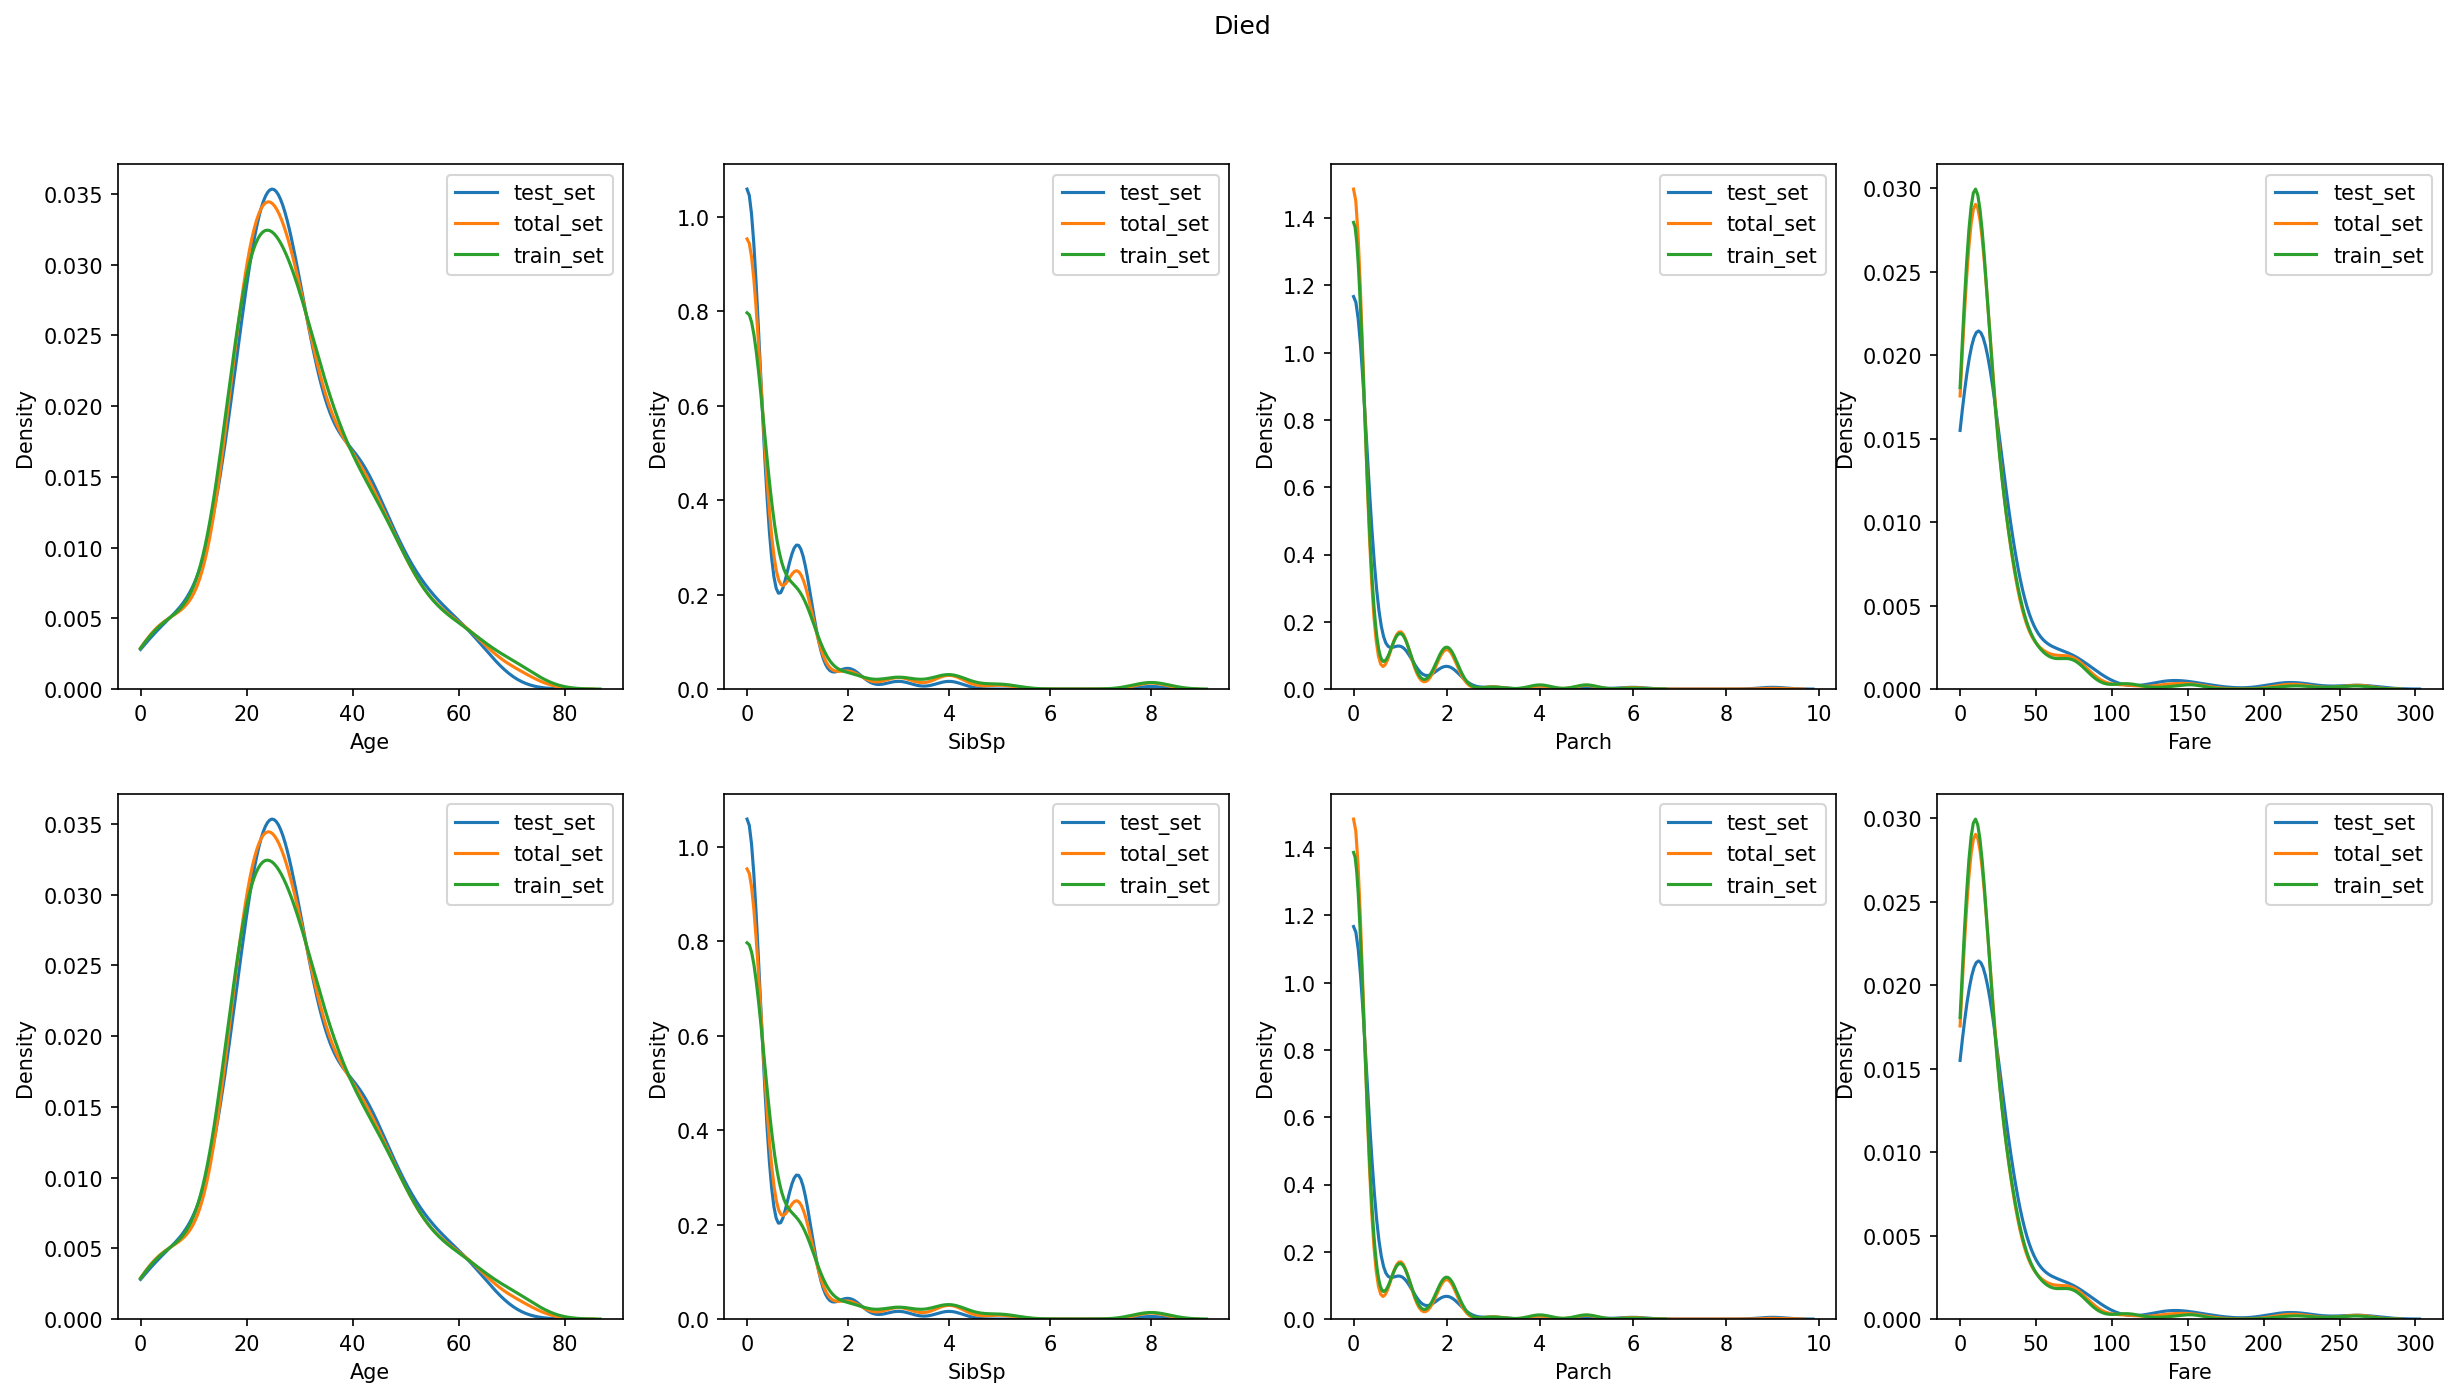

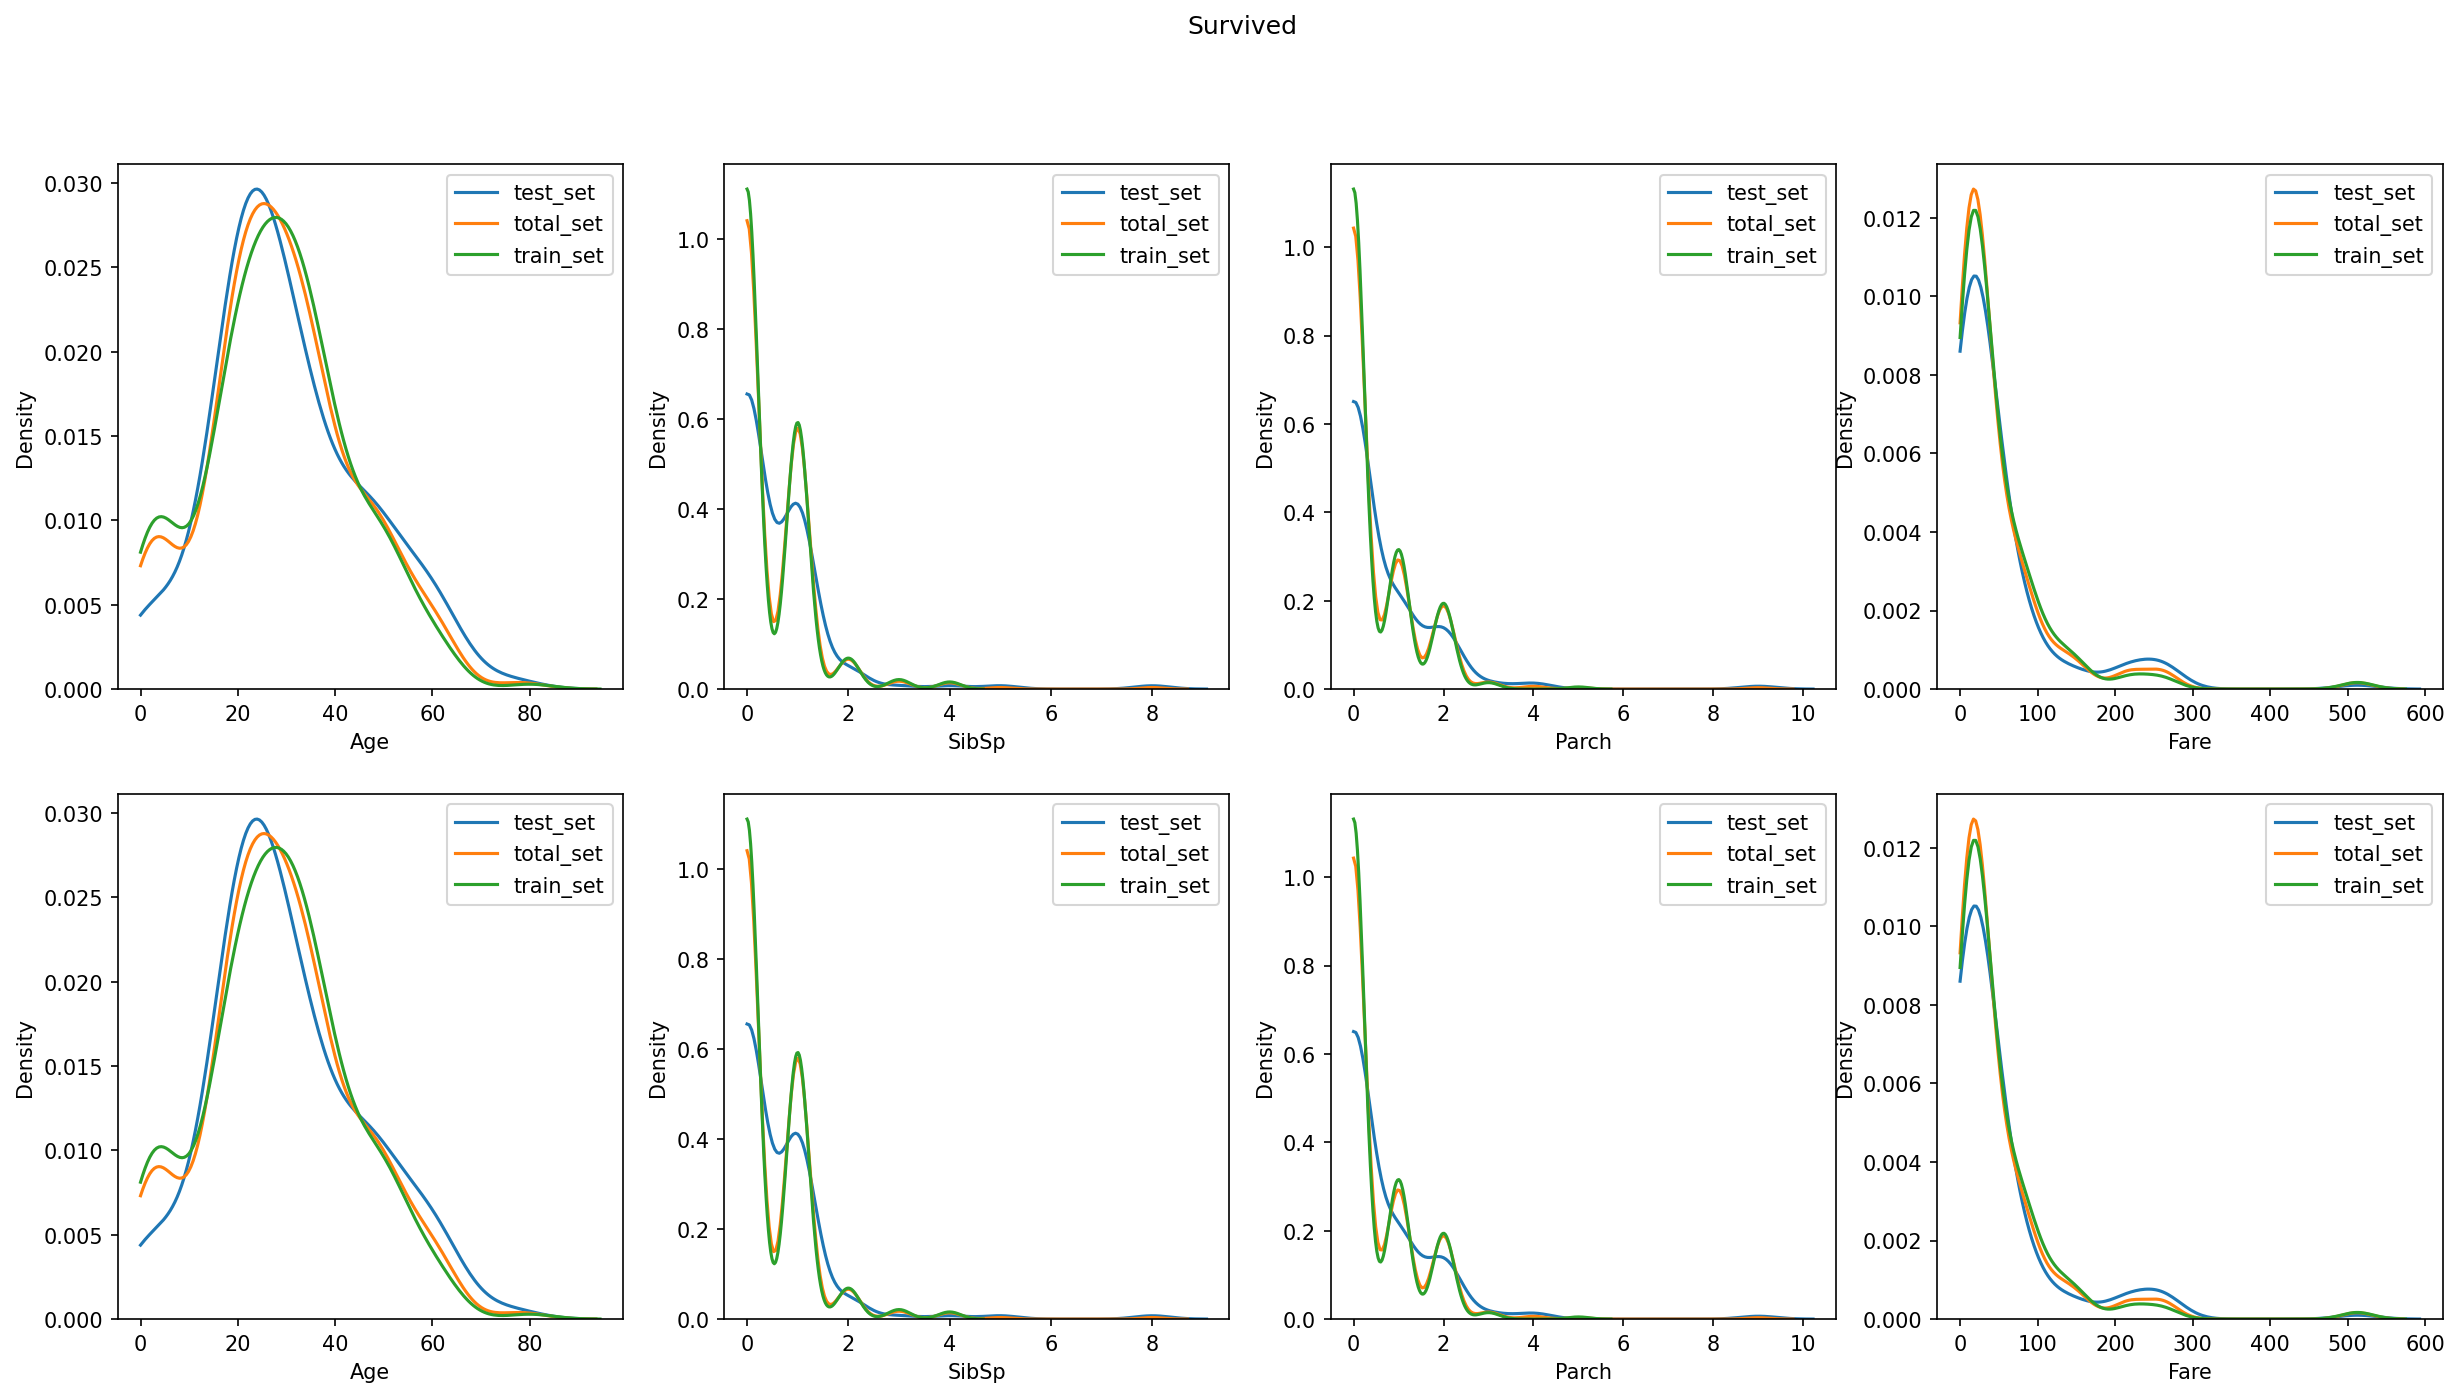

In [5]:
numerical_df = total_df.select_dtypes(include=['float', 'int'])
numerical_cols = numerical_df.columns

numerical_df['Survived'] = total_df['Survived']

survival_dict = {k: v.drop(labels=['Survived'], axis = 1) for k, v in numerical_df.groupby('Survived')}
for survival_state, df in survival_dict.items():
    
    fig, axes = plt.subplots(len(survival_dict), len(numerical_cols), figsize= (5 * len(numerical_cols), 5*len(survival_dict)))
    fig.suptitle(survival_state)
    groups = df.groupby(level=0)
    for ax_row in axes:
        for name, group in groups:
            group = group.droplevel(0)
            for ax, col in zip(ax_row, numerical_cols):
                series = group[col]
                sns.kdeplot(series, ax=ax, label = name, clip = [0, None])
        [ax.legend() for ax in ax_row]

            

# Altering data 


Inspiration taken from : 
* https://www.kaggle.com/code/gbellport/simple-titanic-data-analysis-w-cabin
* https://medium.com/swlh/ways-to-handle-continous-column-missing-data-its-implementations-4704f52ac9c3

In [6]:
def func(row):
    if not type(row) is list:
        return row
    else:
        cabins = [[x[0], int(x[1:])] for x in row if x[0].isalpha() and x[1:].isnumeric()]
        cabin_letter = list(set([cabin[0] for cabin in cabins]))
        try:
            cabin_mean = sum([cabin[1] for cabin in cabins]) / len(cabins)
            return f'{cabin_letter[0]},{cabin_mean}'
        
        except:
            return np.NaN
        
def replace_na_with_sample(x):
    counts = x.value_counts(normalize=True)
    if counts.sum():
        values = counts.index
        p = counts.values
        to_replace = x.isna()
        x[to_replace] = np.random.choice(values, size = to_replace.sum(), p = p)
    return x  

def imputations_by_categories(df, **kwargs):
    filled_columns = kwargs['filled_columns']
    categories = kwargs['categories']
    for column in categories:
        # +1 needed for walrus
        combination_length = len(filled_columns) + 1
        col = df[column]
        nan_idx = col.isna()
        while (combination_length := combination_length - 1) > 1 and \
            (nan_idx := (col := df[column]).isna()).sum():
            all_combinations = combinations(filled_columns, combination_length)
            col = col.to_frame()
            for combination in all_combinations:
                col[combination] = df.groupby(level = 0)\
                    .apply(lambda x: x.groupby(list(combination), group_keys=False)[column]\
                        .apply(lambda x: replace_na_with_sample(x))).droplevel(level = 0)
            
            filled_columns = filled_columns.union([column])
            col = col.drop(columns = column)
            df[column][nan_idx] = col[nan_idx].mode(axis = 1)[0]
    return df, filled_columns

In [7]:
# Filling NA cabins with ppl from same ticket
total_df['Cabin'] = total_df.groupby('Ticket', group_keys=False)['Cabin'].apply(lambda x: x.fillna(' '.join(x.unique().astype(str).tolist())))

# If  multiple cabins per row, take average for room number
indiviual_cabins = total_df['Cabin'].str.split(' ')
modified_cabins = indiviual_cabins.apply(func).fillna(False)
split_cabins = modified_cabins.str.split(',', expand=True).rename(columns={i : name for i, name in enumerate(['Deck', 'Room number'])})
split_cabins['Room number'] = split_cabins['Room number'].astype(float)
new_df = total_df.join(split_cabins.rename_axis(total_df.index.names)).drop(columns='Cabin')

# Join Parck and Sibsp into family 
new_df['Family size'] = total_df['SibSp'] + total_df['Parch']
new_df = new_df.drop(columns=['SibSp', 'Parch'])

# Map titles to reduce number of catergories
titles = new_df['Name'].str.extract('([A-Za-z]+)\.')
title_list = [['Miss', 'Ms','Mlle'],
['Mrs', 'Mme'],
['Royal','Don','Dona','Lady','Sir','Countess','Jonkheer'],
['Other','Rev','Major','Col','Capt','Dr']]

new_df['Title'] = titles.replace({key : value for value, *keys in title_list for key in keys})

# Filter data to be imputed
nan_columns = new_df.drop(columns=['Survived', 'Name', 'Ticket']).isna().sum().astype(bool)
filled_columns = nan_columns[~nan_columns].index
nan_columns = nan_columns[nan_columns].index
 

# First impute categorical columns
categories = new_df[nan_columns].select_dtypes(include=['object']).columns
categories = new_df[categories].isna().sum().sort_values().index
new_df[categories] = new_df[categories].astype('category')

new_df, filled_columns = imputations_by_categories(new_df, filled_columns=filled_columns, categories=categories)

new_df['Room number'] = new_df.groupby('Deck', group_keys=False)['Room number'].apply(lambda x: x.fillna(x.mean()))

# Update small categories
nuniques = new_df.apply(lambda x: x.nunique())
small_catergories = nuniques[nuniques < cutoff].index
new_df[small_catergories] = new_df[small_catergories].astype('category')

new_df['Age'] = new_df['Age'].round().astype('Int8')
new_df, filled_columns = imputations_by_categories(new_df, filled_columns=filled_columns, categories=['Age'])
    

# Training the data

<Axes: >

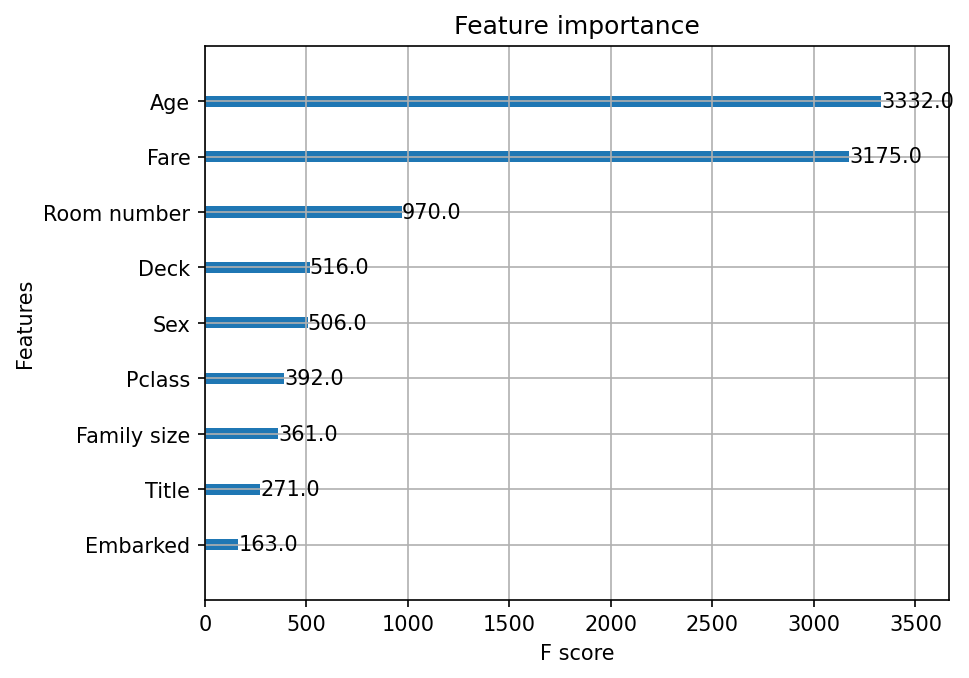

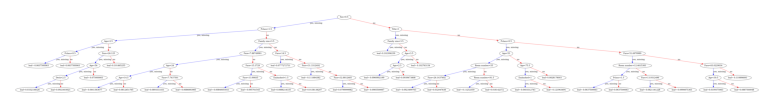

In [12]:
LE = LabelEncoder()


train_df = new_df.select_dtypes(exclude=['object'])
train_df['Age'] = train_df['Age'].astype('int')
train_set = train_df.loc['train_set']
variables = train_set.drop(['Survived'], axis = 1)
test_set = train_df.loc['test_set']
train_labels = LabelEncoder().fit_transform(train_set['Survived'])
dtrain = xgb.DMatrix(variables, label=train_labels, enable_categorical=True)
dtrain.get_data()

params = {
    'booster' : 'gbtree',
    'verbosity' : 1,
}

a= xgb.train(params, dtrain, 250)
xgb.plot_importance(a)
xgb.plot_tree(a, num_trees=1)
